# The traslative and rotational dynamics of a two dimensional ship cargo system; described by solving differential equations using numerical ODE solvers.

To maintain a ships integrity, it's vital that its hull is to be positioned such that no water may enter the cavity of the ship. We will henceforth in this notebook describe mathematically the mechanics which decides whether or not a ship capsizes due to its translational and rotational dynamics. The motion of the ship will be described by differential equations, which are mainly based on Newton's second law of motion and rotation. The important forces that are analyzed are buoyancy and gravity, but additional forces such as friction between the ship and the water and harmonically varying forces as a result of waves / wind will also be of great importance to us. As the model becomes more complex and realistic, cargo will be introduced on the ship. Here, two different situations will mainly be studied, one where the cargo has the opportunity to fall, and and one where it remains on the ship as a result of railings on the ship. We will be simplifying the problem by considering the two dimensional case, and we will furthermore neglect to consider the fluidmechanical aspects. 

In order to solve this problem, we will activly employ numerical methods, namely to solve differential equations and to find roots of functions. The numerical methods we use in this project are Euler's method, Runge-Kutta of order 4, and the Bogacki-Shampine method. We will be using Newton's method to find roots.

In [1]:
from IPython.display import Image, display

The following diagrams displays the system we will be working with, including points of interest: 

the metacenter M,

the center of mass C,

the center of mass of the submerged part of the ship B, 

the vertice K, 

deepest point on the ship, D. 


Including values of interest:

the displacement angle $\theta$ (which is positive counter clockwise),

the angle between the intersection of the lines starting at M and ending at the intersections between the boat and the water at equillibrium $\beta$,

the analogous angle when not necesseraly at equillibrium $\gamma$.


We have also described every force we will encounter throughout this notebook:

the normal forces $N_{cargo}, N_{ship}$,

the frictional forces $f_{cargo}, f_{ship}, f_k$,

the buoyance force $F_b$,

the gravitational forces $G_{ship}, G_{cargo}$,

and the forced oscillation force $F_w$.

Further, notice that the water level is set at y = 0


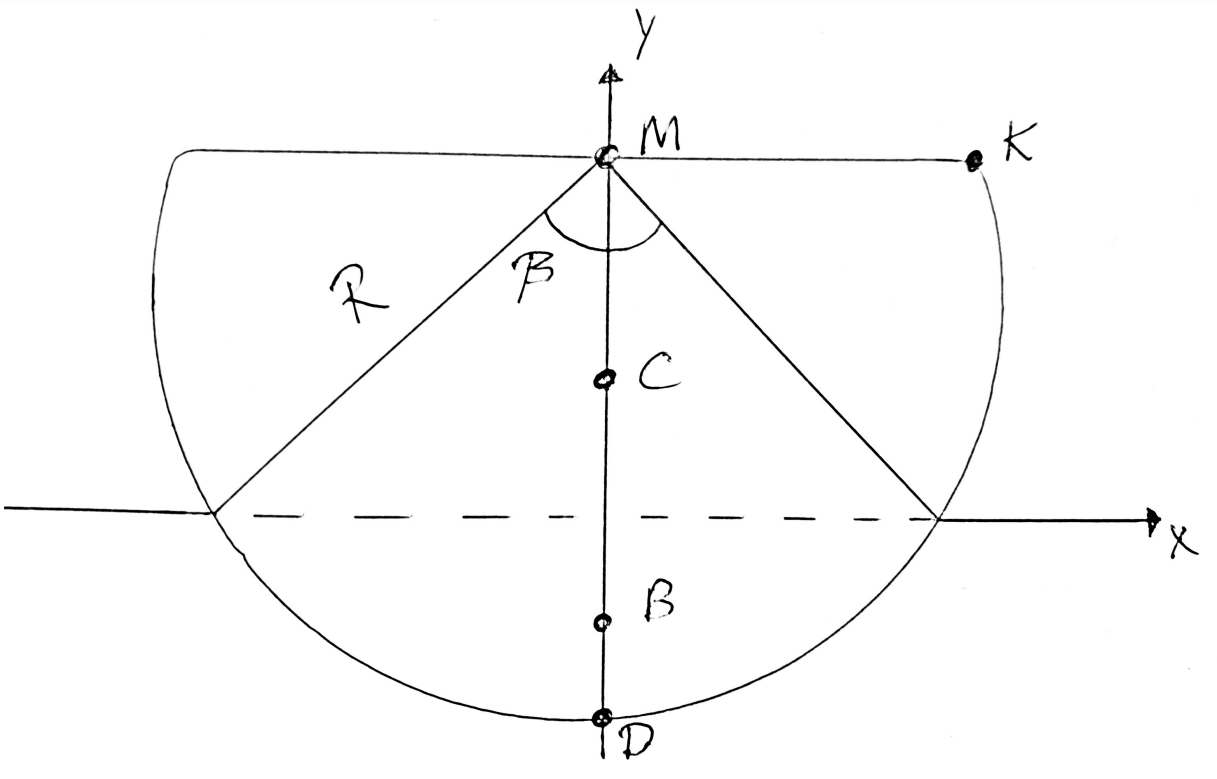

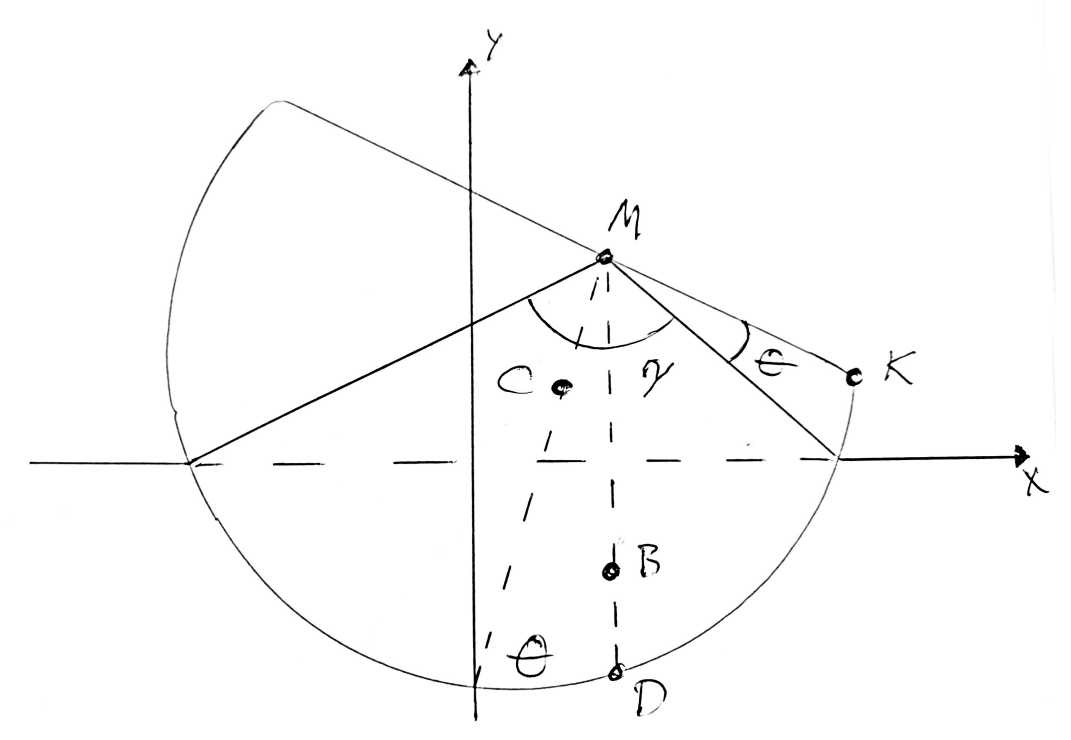

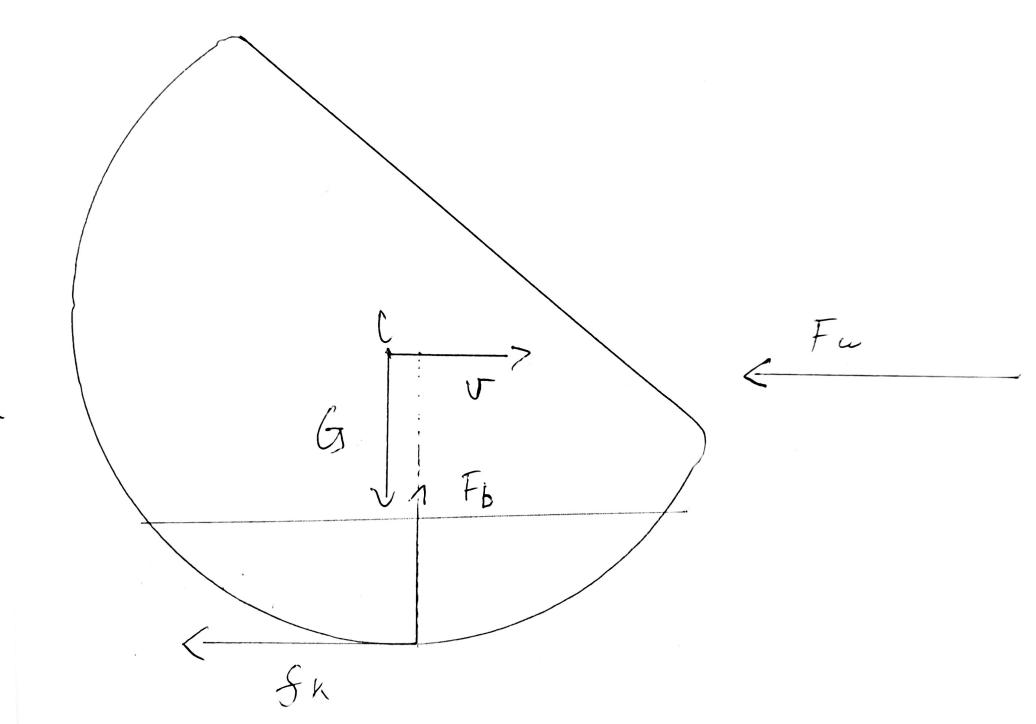

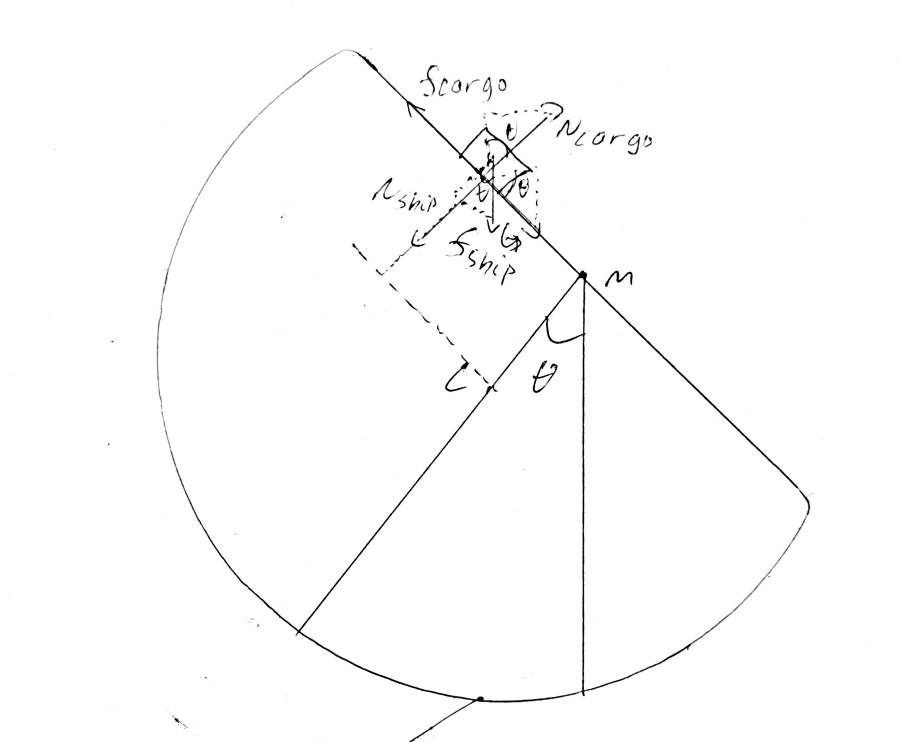

In [2]:
for i in range(1, 4+1):
    display(Image(f"Diagram_{i}.PNG", width=400, unconfined=True))

In [3]:
def remove_old_files():
    import os
    for filename in os.listdir('.'):
        if filename.endswith(".npz"):
            os.remove(filename)


remove_old_files()


In [4]:
"""""""""
Importing libraries.
"""""""""

import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
%matplotlib inline


# TASK 1

We start by defining constant quantities in our physical system. The ship is naturally on water, so we will need the density of water at sea ​​level. Further constants related to the ship are its radius, and its the hull density. Using this, we may easily calulate the mass of the ship, its moment of inertia, and the distance from the ships metacenter and its center of mass.

In [5]:
"""""""""
Setting system parameters
"""""""""

WATER_DENSITY = 1000  # [kg/m²] Water density
SHIP_DENSITY = 500  # [kg/m²] Density of the ship
SHIP_RADIUS = 10  # [m] the cross section of the ship is a semicircle, with radius SHIP_RADIUS
SHIP_AREA = 0.5*np.pi*(SHIP_RADIUS)**2  # [m²] area of semicircle
SHIP_MASS = SHIP_AREA*SHIP_DENSITY  # [kg] the mass of the ship
SHIP_INERTIA = 0.5*SHIP_MASS*(SHIP_RADIUS)**2*(1 - 32/(9*np.pi**2))  # [kgm²] The ship's moment of inertia

A_0 = (0.5*SHIP_DENSITY*np.pi*(SHIP_RADIUS)**2)/(WATER_DENSITY) # [m²] Area of ship submerged under water

DISTANCE_MC = 4*SHIP_RADIUS/(3*np.pi)  # [m] distance from the ship's metacenter to the ship's mass center
GRAV_ACC = 9.81  # [m/s²] acceleration due to gravity
RESONANCE_FREQUENCY = np.sqrt(SHIP_MASS * DISTANCE_MC * GRAV_ACC/SHIP_INERTIA)  # Resonance frequency of the ship


## 1a)

We will now calculate the sector angle $\beta$, which is the angle made by the two lines starting at the metacenter which pass through the intersection between the water surface and the ship, when the system is at equilibrium.

From Archimedes law we have that the area $A_0$, which is the area of the boat which is submerged under water, is given by:

$A_0 = \frac{\sigma \pi R^2}{2\sigma_0}$

But we may also find $A_0$ by considering the geometry of the problem giving:

$A_0 = \frac{1}{2}R^2(\beta - \sin{\beta})$

Thus we may conclude that:

$\beta - \sin{\beta} = \pi \frac{\sigma}{\sigma_0}$

Which unfortunatly isn't an explicit function for $\beta$, though as it is given implicitly, we may still solve it using numerical methods. We have here chosen to use newtons method.

In [6]:
def newton_method(f, fPrime, x0, L, tol=1e-14, maxIter=30):
    """Implementation of newtons method, which considers an 
    upper error estimate


    Args:
        f (function): f(x) = 0
        fPrime (function): f'(x)
        x0 (ArrayLike): initial guess at root
        L (float): used to determine upper errorbound
        tol (float, optional): maximum allowed error. Defaults to 1e-14.
        maxIter (int, optional): maximum number of iterations. Defaults to 30.

    Returns:
        tuple[ArrayLike, float]: root of the function and error estimate
    """
    err = float("inf")
    x1 = x0
    for _ in range(maxIter):
        x1 = x0 - f(x0)/fPrime(x0)
        err = np.linalg.norm(L/(L-1)*(x1-x0))
        if err < tol:
            break
        x0 = x1
    else:
        print("Warning: Maximum iterations reached")
    return x1, err


def calculate_beta(cargo_mass=0):
    """Calculates the central angle of the ship at equilibrium with the given total cargo mass

    Args:
        cargo_mass (int, optional): mass of the cargo. Defaults to 0.
    
    Returns:
        tuple[float, float]: The central angle, and the error estimate
    """
    def f(x):
        return x - np.sin(x) - np.pi*(SHIP_DENSITY + cargo_mass/SHIP_AREA)/WATER_DENSITY

    def fPrime(x):
        return 1 - np.cos(x)

    b0 = 1
    L = 2
    beta, err = newton_method(f, fPrime, b0, L)
    return beta, err


BETA, error = calculate_beta()

In [7]:
print(f'The sector angle when the ship is at rest is: {BETA:.17f} +- {error:.17f}')

The sector angle when the ship is at rest is: 2.30988146001005745 +- 0.00000000000000089


## 1b)

Now that we have found an approximate value for $\beta$, we may now use it to find various values relating to the system at equilibrium. Namely:

$y_{(MB)_0}$, which is the distance from the metacenter to the center of gravity for the part of the boat which is submerged under water.

$y_{M_0}$, which is the distance from the water surface to the metacenter.

$y_{C_0}$, which is the distance from the water surface to the center of gravity.

$y_{B_0}$, which is the distance from the water surface to the center of gravity of the part of the boat submerged under water.

$y_{D_0}$, which is the distance from the water surface to the bottom of the hull of the ship. 

We refer to Figure 1 to give a visual overview of the location of these points.

All heights are calculated relative to the water level.

In [8]:
Y_MB_0 = 4*SHIP_RADIUS*(np.sin(BETA/2))**3/(3*(BETA - np.sin(BETA)))
Y_M_0 = SHIP_RADIUS*np.cos(BETA/2)
Y_C_0 = Y_M_0 - DISTANCE_MC
Y_B_0 = Y_M_0 - Y_MB_0
Y_D_0 = Y_M_0 - SHIP_RADIUS

In [9]:
print(f'The metacenter: {Y_M_0:.6}')
print(f'The center of gravity: {Y_C_0:.6}')
print(f'The buoyancy center - the point where the buoyancy force acts: {Y_B_0:.6}')
print(f'The ships deepest point: {Y_D_0:.6}')

The metacenter: 4.03973
The center of gravity: -0.204404
The buoyancy center - the point where the buoyancy force acts: -2.45792
The ships deepest point: -5.96027


We will in the following calculation only look at two forces, the gravitational force and the buoyancy force. The center of mass and the displaced water may be assumed to be constant, in order to simplify the calculations, which these assumptions do in that we only need to look at the torque resulting from the buoyancy force. We may then describe the dynamics of the ship soley by the following equation:

$$ \sum \tau = I_C \frac{d\omega}{dt} $$

which is Newton's second law of rotation.

## 1c)
We will now introduce the system state function $\vec{w}(t)$, which we will use to store information about the state of the system in a given time interval.

Let $\vec{w}(t)$ be defined such that:

$\vec{w}(t) = \begin{pmatrix} \theta (t) \\ \dot{\theta}(t) \end{pmatrix} = \begin{pmatrix} \theta (t) \\ \omega (t) \end{pmatrix}$

Let now $\vec{f}(t)$ be defined such that:

$\frac{d\vec{w}(t)}{dt} = \vec{f}(t) = \begin{pmatrix} f_1(t) \\ f_2(t) \end{pmatrix}$

Thus $f_1(t) = \omega (t)$, whilst $f_2(t) = \dot{\omega}(t)$ which may be calculated explicitly by considering the torque:

$\tau = \sum_{k \in I} \tau_k = -F_b h \sin{\theta} = I_c \ddot{\theta} = I_c \dot{\omega} \implies f_2(t) = \dot{\omega} = -\frac{F_b h \sin{\theta}}{I_c}$

$I_c$ is the inertia of the ship, and $h$ is the distance from the metacentre to the center of mass. 

$F_b$ is the buoyancy given by:

$F_b = A \sigma _0 g$, where $A$ refers to the area of the ship which is submerged under water.

$A = \frac{1}{2} R^2 (\gamma - \sin{\gamma}),$

$\gamma = 2\cos^{-1}[{\cos{\frac{\beta}{2}} - \frac{4}{3 \pi}(1 - \cos{\theta})}]$

Too simplify this we may assume $\gamma \approx \beta$, giving:

$A \approx A_0  = \frac{1}{2} R^2 (\beta - \sin{\beta})$

## 1d)

We will now need to develop a numerical method to solve the equations given above. As this is a system of differential equations, a Runge Kutta method would be an ideal way to do this. We will initially be using Euler's method, which is a first order method, in order to keep the problem simple.

In [10]:
def derivative_simple_torque(t, w):
    """Calculates the derivative of w, considering: 
    
    - The torque from the buoyance force, with constant submerged area

    Args:
        t (float): time
        w (np.ndarray): vector of form [theta, omega]

    Returns:
        np.ndarray: derivative of form [d theta, d omega]
    """
    force_buoy = GRAV_ACC*WATER_DENSITY * A_0  # [N] buoyancy force
    return np.array([w[1],
                     -force_buoy*DISTANCE_MC*np.sin(w[0])/SHIP_INERTIA])


def euler_method(func, b0, ta, tb, dt, *, retstep=False, **fkwargs):
    """Runs the Euler method on the given input

    Args:
        derivative (callable(float, np.ndarray, **kwargs)->np.ndarray): Derivative function, returns array of derivative of each element in the input array
        b0 (np.ndarray): initial state of the system
        ta (float): start time
        tb (float): end time
        dt (float): approximate size of the time step
        retstep (bool, optional): If True, return (t, w_array, step), where step is the spacing between samples. Defaults to False.

    Returns:
        tuple[np.ndarray, np.ndarray]: array of times, and the corresponding evaluated system states
    """
    num_iter = int((tb-ta)/dt)
    t, dt = np.linspace(ta, tb, num_iter + 1, retstep=True)
    w_array = np.zeros((len(b0), num_iter + 1))
    w_array[:, 0] = wn = b0

    for i in range(num_iter):
        w_array[:, i+1] = wn = wn + dt * func(t[i], wn, **fkwargs)

    if retstep:
        return t, w_array, dt
    return t, w_array


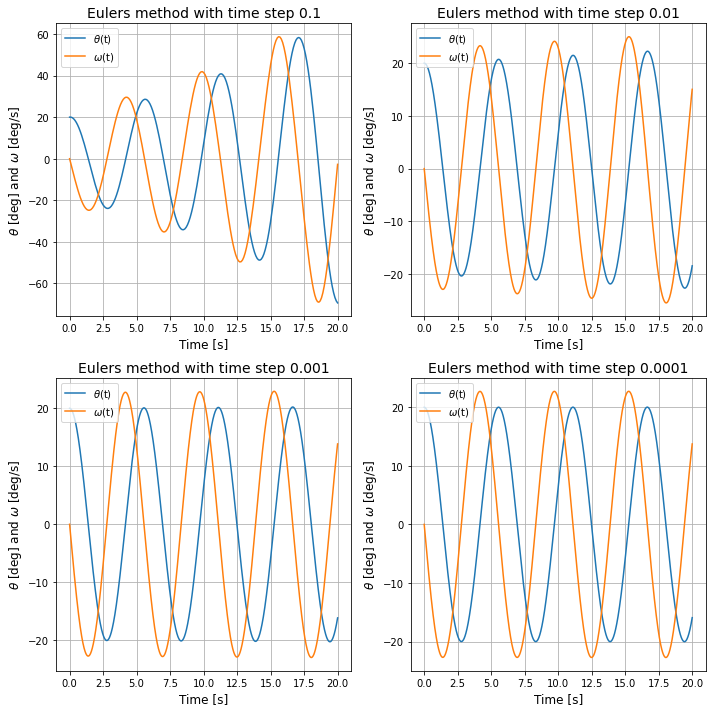

In [11]:
def test_euler():
    """Runs the euler method with time-steps of differing sizes, and plots the result for visual inspection
    """
    ta, tb = 0, 20
    theta_0, omega_0 = np.deg2rad(20), 0
    b0 = np.array([theta_0, omega_0])
    time_step = [0.1, 0.01, 0.001, 0.0001]
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, dt in enumerate(time_step):
        t, result = euler_method(derivative_simple_torque, b0, ta, tb, dt)
        ax = axes[i//2, i % 2]
        ax.plot(t, np.rad2deg(result[0]), label="$\\theta$(t)")
        ax.plot(t, np.rad2deg(result[1]), label="$\\omega$(t)")
        ax.set_title(f'Eulers method with time step {dt}', fontsize=14)
        ax.set_xlabel('Time [s]', fontsize=12)
        ax.set_ylabel('$\\theta$ [deg] and $\\omega$ [deg/s]', fontsize=12)
        ax.grid(True)
        ax.legend()
        
    plt.tight_layout()
    plt.show()


test_euler()


The amplitude in the function can be seen to increase over time, doing so to a greater extent for bigger time steps. This is analogous to an the energy increasing over time, which is of course unnatural behaviour. This showcases one of the major drawback with numerical methods, though it also shows that this drawback becomes negligeble for sufficiently small values for the time steps. In this case dt = 0.001 seems to be sufficient. Using 0.0001 as a timestep would be redundant. 

## 1e)
We will now be analyzing the small angle aproximation. To do so, we will consider the following equation:

$$ \frac{d^2\theta}{dt^2} = \frac{-mgh}{I_C}\theta $$

Which is equivalent to:

$$ \frac{d\omega}{dt} = \frac{-mgh}{I_C}\theta$$

We have here used the small angle approximation $\theta \approx \sin{\theta}$, meaning that the original equation looks like this:

$$ \frac{d\omega}{dt} = \frac{-mgh}{I_C}\sin(\theta)$$

This is an embarrassingly commonly used  approximation used in physics, and we will now study how good this approximation is.

We will thus solve the equation with and without the small angle approximation, using  two different initial values ​​for the starting angle, and compare the results. We will be using Euler's method in this calculation

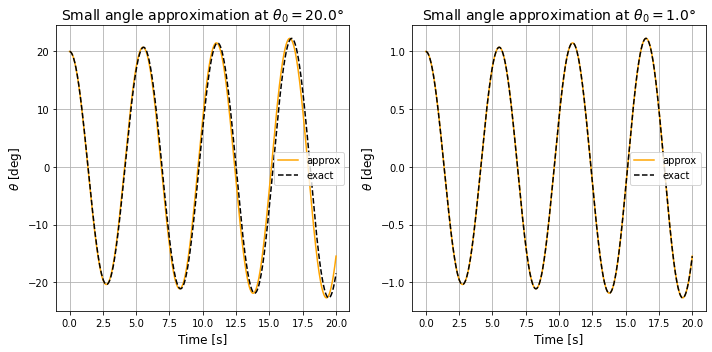

In [12]:
def derivative_simple_approx(t, w):
    """Calculates the derivative of w using the small angle approximation, considering: 

    - The torque from the buoyance force, with constant submerged area

    Args:
        t (float): time
        w (np.ndarray): vector of form [theta, omega]

    Returns:
        np.ndarray: derivative of form [d theta, d omega]
    """
    force_grav = GRAV_ACC*SHIP_MASS
    return np.array([w[1],
                     -force_grav*DISTANCE_MC*w[0] / SHIP_INERTIA])


def derivative_simple_exact(t, w):
    """Calculates the derivative of w without using small angle approximation, considering: 

    - The torque from the buoyance force, with constant submerged area

    Args:
        t (float): time
        w (np.ndarray): vector of form [theta, omega]

    Returns:
        np.ndarray: derivative of form [d theta, d omega]
    """
    force_grav = GRAV_ACC*SHIP_MASS
    return np.array([w[1],
                     -force_grav*DISTANCE_MC*np.sin(w[0]) / SHIP_INERTIA])


def compare_exact():
    """Compares the difference obtained from using small angle approximation at theta = [20, 1] degrees with eulers method
    """
    ta, tb, dt = 0, 20, 0.01
    omega_0 = 0
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    thetas = (np.deg2rad(20), np.deg2rad(1))
    for i, theta_0 in enumerate(thetas):
        b0 = np.array([theta_0, omega_0])
        t_approx, result_approx = euler_method(derivative_simple_approx, b0, ta, tb, dt)
        t_exact, result_exact = euler_method(derivative_simple_exact, b0, ta, tb, dt)

        ax = axes[i]

        ax.plot(t_approx, np.rad2deg(result_approx[0]), "orange", label="approx")
        ax.plot(t_exact, np.rad2deg(result_exact[0]), "--k", label="exact")
        ax.set_title(f"Small angle approximation at $\\theta_0 = ${np.rad2deg(theta_0)}$\\degree$", fontsize=14)
        ax.set_xlabel('Time [s]', fontsize=12)
        ax.set_ylabel('$\\theta$ [deg]', fontsize=12)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


compare_exact()


From the lower graph, where we have a starting angle of 1 degree, we see that the small angle approximation coincides basicly exactly with the analytical solution. This is as expected, because 1 degree in radians is approximatly 0.02, which is tiny, so the angle is small enough for the small angle approximation to be good. We further see that a significantly larger starting angle, here 20 degrees, causes the exact and the approximate solution to diverge from each other. This is strictly also true for the 1 degree case as well, though for the 20 degree case it happens almost immediately. 

## 1f)

In [13]:
def RK4Step(derivative, wn, t_i, dt, **kwargs):
    """Runs one step of the Runge-Kutta method of the 4th other

    Args:
        derivative (callable(float, np.ndarray, **kwargs)->np.ndarray): Derivative function, returns array of derivative of each element in the input array
        wn (np.ndarray): current state of the system
        t_i (float): current time
        dt (float): size of the time-step

    Returns:
        np.ndarray: the next state of the system
    """
    k1 = derivative(t_i, wn, **kwargs)
    k2 = derivative(t_i + dt*0.5, wn + dt*k1*0.5, **kwargs)
    k3 = derivative(t_i + dt*0.5, wn + dt*k2*0.5, **kwargs)
    k4 = derivative(t_i + dt, wn + dt*k3, **kwargs)

    return wn + dt/6 * (k1 + 2*k2 + 2*k3 + k4)


def RK4(derivative, b0, ta, tb, dt, *, retstep=False, **fkwargs):
    """Runs the Runge-Kutta of method the 4th order on the given input

    Args:
        derivative (callable(float, np.ndarray, **kwargs)->np.ndarray): Derivative function, returns array of derivative of each element in the input array
        b0 (np.ndarray): initial state of the system
        ta (float): start time
        tb (float): end time
        dt (float): approximate size of the time step
        retstep (bool, optional): If True, return (t, w_array, step), where step is the spacing between samples. Defaults to False.

    Returns:
        tuple[np.ndarray, np.ndarray]: array of times, and the corresponding evaluated system states
    """

    num_iter = int((tb-ta)/dt)
    t, dt = np.linspace(ta, tb, num_iter + 1, retstep=True)
    w_array = np.zeros((len(b0), num_iter + 1))
    w_array[:, 0] = b0
    
    for i in range(num_iter):
        w_array[:, i+1] = RK4Step(derivative, w_array[:, i], t[i], dt, **fkwargs)

    # Returning results
    if retstep:
        return t, w_array, dt
    return t, w_array


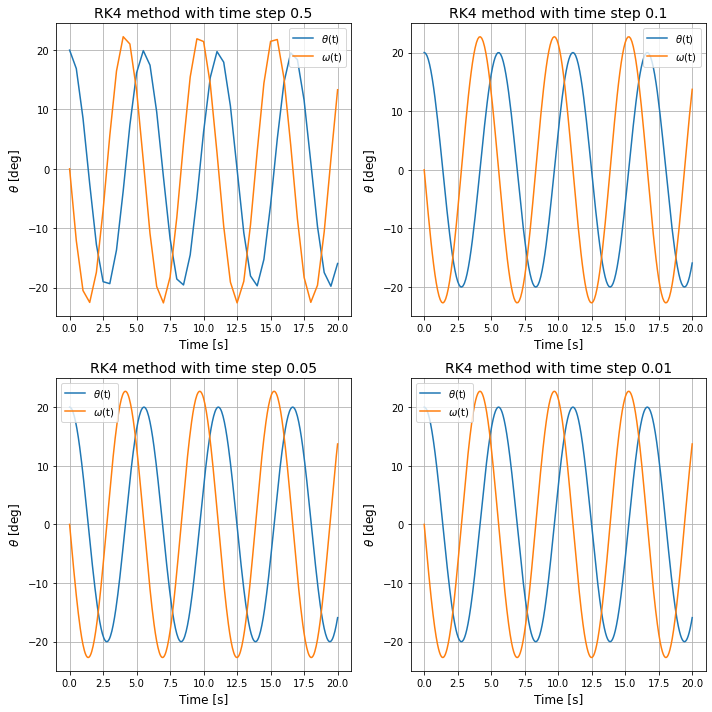

In [14]:
def testRK4():
    """Runs the RK4 method with time-steps of differing sizes, and plots the result for visual inspection
    """
    ta, tb = 0, 20
    b0 = np.array([np.deg2rad(20), 0])

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    time_steps = (0.5, 0.1, 0.05, 0.01)
    for i, dt in enumerate(time_steps):
        ax = axes[i//2, i%2]
        t, result = RK4(derivative_simple_torque, b0, ta, tb, dt)
        ax.plot(t, np.rad2deg(result[0]), label="$\\theta$(t)")
        ax.plot(t, np.rad2deg(result[1]), label="$\\omega$(t)")
        ax.set_title(f'RK4 method with time step {dt}', fontsize=14)
        ax.set_xlabel('Time [s]', fontsize=12)
        ax.set_ylabel('$\\theta$ [deg]', fontsize=12)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


testRK4()


## 1g)

We will now solve the following ODE analytically:

$-mgh\theta = I_C \frac{d\omega}{dt}$

We have thus emploied the small angle approximation.

If we let $\vec y(t) = \begin{pmatrix} \theta(t) \\ \omega(t) \end{pmatrix}$ then it follows that:

$\vec y'(t) = A\vec y(t)$, with $A = 
   \begin{pmatrix} 
      0 & 1 \\ 
      -\alpha^2 & 0 
   \end{pmatrix}
$, $\alpha^2 = \frac{mgh}{I_c}$.

Clearly the solution must thus be:

$\vec y(t) = \vec be^{At}$, since $\vec y'(t) = A\vec be^{At} = A\vec y$, where $\vec y(0) = \vec b = 
\begin{pmatrix} 
      \theta_0\\ 
      \omega_0
   \end{pmatrix}$.

We have thus reduced the ODE to the problem of solving $e^{At}$.

To do this we must first find a matrix $\Gamma$ such that $A \sim \Gamma$, where $e^{\Gamma}$ is directly computable.

We see that the eigenvalues to $A$ are $\lambda = \pm \alpha i$ which tells us that $\Gamma$ ought to be in a real cannonical form, namely $\Gamma = 
\begin{pmatrix} 
    0 & -\alpha \\ 
    \alpha & 0 
\end{pmatrix}$
. If we compute the eigenvectors to $A$ we get $v = \begin{pmatrix} 
    1\\
    0 
\end{pmatrix}
\pm i
\begin{pmatrix} 
    0\\
    -\alpha 
\end{pmatrix}$

Telling us that we may construct the matrix $P = \begin{pmatrix} 
    1 & 0\\
    0 & -\alpha 
\end{pmatrix}$
, which is defined such that $AP = P \Gamma$, or $A = P \Gamma P^{-1}$.
So $e^{At} = Pe^{\Gamma t}P^{-1}$. Thus we just have to caluculate $e^{\Gamma}$ to finaly be able to solve the problem.
Note that $\Gamma = 0I + \alpha J$, where $I = 
\begin{pmatrix} 
    1 & 0\\
    0 & 1 
\end{pmatrix}$
, and $J = 
\begin{pmatrix} 
    0 & -1\\
    1 & 0 
\end{pmatrix}$
.

$e^{\Gamma} = e^{0I + \alpha J} = e^{0I}e^{\alpha J} = \sum_{k=0}^{\infty} \frac{(\alpha J)^k}{k!} = \frac{I}{0!} + \frac{\alpha J}{1!} - \frac{\alpha^2 I}{2!} - \frac{\alpha^3 J}{3!} + ... = I(1-\frac{\alpha^2}{2}+...) + J(\frac{\alpha}{1!} - \frac{\alpha^3}{3!} + ...) = I \cos{\alpha} + J \sin{\alpha}$.

Thus $e^{At} = P e^{\Gamma t} P^{-1} = 
\begin{pmatrix} 
    \cos{\alpha t} & \frac{\sin{\alpha t}}{\alpha}\\
    -\alpha \sin{\alpha t} & \cos{\alpha t} 
\end{pmatrix}$

Finally giving $\theta(t) = \theta_0 \cos{\alpha t} + \omega_0 \frac{\sin{\alpha t}}{\alpha}$


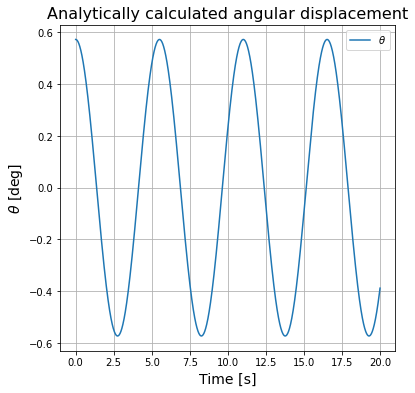

In [15]:
def theta_tilde(t, theta_0, omega_0):
    """Calculates the analytical solution of the small angle approximated simple system

    Args:
        t (ArrayLike): int or array of t-values to calculate the analytical solution for
        theta_0 (float): initial angular displacement
        omega_0 (float): initial angular velocity

    Returns:
        ArrayLike: array of same shape as t with analytical solutions
    """
    alpha = np.sqrt(SHIP_MASS*GRAV_ACC*DISTANCE_MC/SHIP_INERTIA)
    return theta_0*np.cos(alpha*t) + omega_0*np.sin(alpha*t)/alpha


def plot_theta_tilde():
    """Plots the analytical solution at of the simple function
    """
    ta, tb, dt = 0, 20, 0.01
    theta_0, omega_0 = 0.01, 0
    
    num_iter = int((tb-ta)/dt)
    t, dt = np.linspace(ta, tb, num_iter + 1, retstep=True)

    theta = theta_tilde(t, theta_0, omega_0)

    plt.figure(figsize=(6, 6))
    plt.plot(t, np.rad2deg(theta), label="$\\theta$")
    plt.title("Analytically calculated angular displacement", fontsize=16)
    plt.xlabel('Time [s]', fontsize=14)
    plt.ylabel('$\\theta$ [deg]', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_theta_tilde()


## 1h)

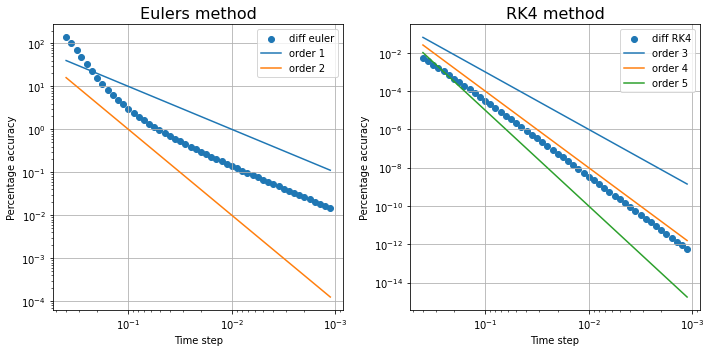

In [16]:
def plot_error():
    """Plots the error from the eulers method and the Runge-Kutta method against the analytical solution at different timesteps, 
    in a log-log scale to find the order of the functions
    """

    # Defining parameters
    ta, tb = 0, 20
    theta_0, omega_0 = 1e-9, 0
    b0 = np.array([theta_0, omega_0])
    dts = 10**(-np.arange(0.4, 3, 0.05))

    # Use analytical solution with good accuracy for all cases
    theta_anal = theta_tilde(tb, theta_0, omega_0)

    diff_RK4 = np.zeros_like(dts)
    diff_euler = np.zeros_like(dts)
    dt_euler = np.zeros_like(dts)
    dt_RK4 = np.zeros_like(dts)

    for i, dt in enumerate(dts):
        t_euler, res_euler, dt_euler[i] = euler_method(derivative_simple_torque, b0, ta, tb, dt, retstep=True)
        diff_euler[i] = abs((theta_anal - res_euler[0][-1])/theta_anal)

        t_RK4, res_RK4, dt_RK4[i] = RK4(derivative_simple_torque, b0, ta, tb, dt, retstep=True)
        diff_RK4[i] = abs((theta_anal - res_RK4[0][-1])/theta_anal)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.set_title("Eulers method", fontsize=16)
    ax1.scatter(dt_euler, diff_euler, label="diff euler")
    for i in range(1, 3):
        ax1.plot(dt_euler, 1e2*dt_euler**i, label=f"order {i}")

    ax1.invert_xaxis()
    ax1.legend()
    ax1.set_xscale('log')
    ax1.set_xlabel('Time step')
    ax1.set_yscale('log')
    ax1.set_ylabel('Percentage accuracy')
    ax1.grid(True)

    ax2.set_title("RK4 method", fontsize=16)
    ax2.scatter(dt_RK4, diff_RK4, label="diff RK4")
    for i in range(3, 6):
        ax2.plot(dt_RK4, dt_RK4**i, label=f"order {i}")

    ax2.invert_xaxis()
    ax2.legend()
    ax2.set_xscale('log')
    ax2.set_xlabel('Time step')
    ax2.set_yscale('log')
    ax2.set_ylabel('Percentage accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


plot_error()


Lowering the value of dt decreases the error, which may readily be seen from the graphs. Furthermore we notice that eulers method decreases slower than the RK4 method. This agrees with the theory which states that eulers method results in the error decreasing linearly in relation to decreased stepsize, whilst the RK4 method results in the error decreasing quarticly, both of these facts are also evident from the graphs

# TASK 2

We will from this point forward let the position of the center of mass, and the amount of displaced water vary. Thus moving away from the naive simplifications we have used hitherto. The most relevant consequence of this is that we will need to modell the forces acting on the system as a whole as well as other torques becoming more nuanced:

$$ \sum \tau = I_C \frac{d\omega}{dt} $$

$$ \sum F = m \frac{d\textbf{V}}{dt} $$

where $\textbf{V}$ can be written in component form, $\textbf{V} = (v_x, v_y)$


## 2a)

We want to have the entire system described in matrix form, akin to how we have done it thus far.

We will, for now at least, content ourselves with a system where the dynamics are soley determined by buoyancy and gravity.

This is an ideal case, in that there are no forces which act in the horizontal direction. Meaning that we may ignore the x-position of the ship.

An expression for $\frac{d\omega}{dt}$, can be found from Newton's second law of rotation:

$$ \frac{d\omega}{dt} = \frac{\sum\tau}{I_C} = -\frac{F_B h \sin(\theta)}{I_C} $$

An expression for $ \frac{dv_y}{dt} $, can be found from Newton's second law of motion:

$$ \frac{dv_y}{dt} = \frac{\sum F_y}{m} = \frac{A\sigma_0g - mg}{m} = \frac{g(A\sigma_0 - m)}{m} $$

It must be noted that x is positive to the right, and y is positive upwards.

We thusly end up with following expression for f:

$$ \vec w = [\theta, \omega, y_c, v_{yc}, x_c, v_{xc}] $$
$$ \vec f = [\omega, \frac{d\omega}{dt} , v_{yc}, \frac{dv_{yc}}{dt}, v_{xc}, \frac{dv_{xc}}{dt}] $$

$$ \vec f = [w[1], -\frac{F_B h \sin(w[0])}{I_C}, w[3], \frac{g(A\sigma_0 - m)}{m}, w[5], 0] $$

$\vec f =
\begin{pmatrix} 
      \omega \\ \\
      \frac{-F_B h \sin(\theta)}{I_C} \\ \\
      y_c \\ \\
      \frac{g (A\sigma_0 - m )}{m} \\ \\
      v_{xc} \\ \\
      0 
   \end{pmatrix}
$

In [17]:
# Give proper description
def derivative_torque_calc_area(t, w):
    """Calculates the derivative of w, considering: 
    
    - The buoyance force
    - The gravitational force

    Args:
        t (float): time
        w (np.ndarray): vector of form [theta, omega, y_C, v_yC, x_C, v_xC]

    Returns:
        np.ndarray: derivative of form [d theta, d omega, d y_C, d v_yC, d x_C, d v_xC]
    """
    delta_Yc = w[2] - Y_C_0
    gamma = 2*np.arccos(np.cos(BETA*0.5) - (4/(3*np.pi)) * (1 - np.cos(w[0])) + delta_Yc/SHIP_RADIUS)
    area_water = 0.5*SHIP_RADIUS**2 * (gamma - np.sin(gamma))
    force_buoy = GRAV_ACC*WATER_DENSITY*area_water  # [N] buoyancy force
    force_grav = SHIP_MASS*GRAV_ACC
    return np.array([w[1],
                    -force_buoy*DISTANCE_MC*np.sin(w[0]) / SHIP_INERTIA,
                    w[3],
                    (force_buoy - force_grav)/SHIP_MASS,
                    w[5],
                    0])


## 2b)

We will now solve the following system as described in problem 1d), but this time we allow the amount of displaced water to vary as a function of the angle. We will then compare these results. 

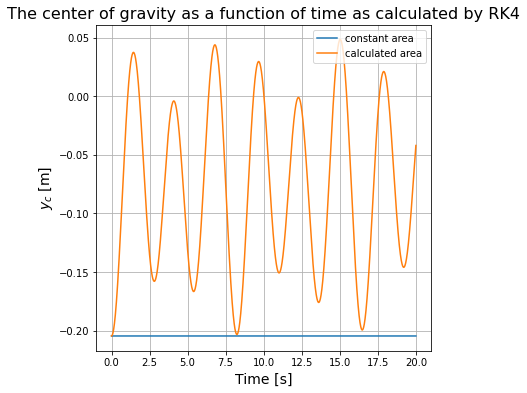

In [18]:
def derivative_torque_const_area(t, w):
    """Calculates the derivative of w, considering: 
    
    - The torque from the buoyance force, with constant submerged area

    Args:
        t (float): time
        w (np.ndarray): vector of form [theta, omega, y_C, v_yC, x_C, v_xC]

    Returns:
        np.ndarray: derivative of form [d theta, d omega, d y_C, d v_yC, d x_C, d v_xC]
    """
    force_buoy = GRAV_ACC*WATER_DENSITY*A_0  # [N] buoyancy force
    force_grav = SHIP_MASS*GRAV_ACC
    return np.array([w[1],
                    -force_buoy*DISTANCE_MC*np.sin(w[0]) / SHIP_INERTIA,
                    w[3],
                    (force_buoy - force_grav)/SHIP_MASS,
                    w[5],
                    0])

def constant_area_comparison():
    """Plots the impact considering a changing submerged area has on the bobbing of the ship
    """
    ta, tb, dt = 0, 20, 0.01
    theta_0, omega_0 = np.deg2rad(20), 0
    b0 = np.array([theta_0, omega_0, Y_C_0, 0, 0, 0])
    t_calc, result_calc = RK4(derivative_torque_calc_area, b0, ta, tb, dt)
    t_const, result_const = RK4(derivative_torque_const_area, b0, ta, tb, dt)

    plt.figure(figsize=(6, 6))
    plt.plot(t_const, result_const[2], label='constant area')
    plt.plot(t_calc, result_calc[2], label='calculated area')
    plt.title("The center of gravity as a function of time as calculated by RK4", fontsize=16)
    plt.xlabel('Time [s]', fontsize=14)
    plt.ylabel('$y_c$ [m]', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()


constant_area_comparison()


We have now plotted the ships center of mass in the y-direction as a function of time for this system, and for the one we studied before. What is readily noticed is that the center of mass remains still for the old case, which was an underlying assumption so this is no surprise, whilst it fluctuates wildly for the more realistic case. Gravity and buoyancy both work together to create oscillations, as the gravity pushes the ship down, whilst the buoyancy pushes it back with a force dependentent on the part of the ship submerged under water as previously described. Due to the ideal conditions imposed on the systems, we find that the oscillations in fact are periodic, though one would expect them to be completley chaotic given more realistic conditions. Though it is worth mentioning that the periodicity of the function confirms that the energy in the system remains constant, which is expected as we haven't added any forms of friction to the system yet.

The most important takeaway here is that removing the mentioned assumption has a big impact on the system, and the assumptioned can therefor not be said to be valid.

## 2c)

We now want to look at situations where the ship capsizes, and want to incorporate this function in our numerical ODE solver. We start by defining when the ship has capsized, and then give a mathematical description of this condition. We say that the ship has capsized when a part of the ship's deck is under water. It is thus only appropriate to look at the lowest point of the ship, given as the point K in our figures. 

We see that if the difference in height of the lowest point on the deck and the metacenter, given by $R|\sin(\theta)|$, is greater than the height of the metacenter, said point must be under water. In other words, the height of the lowest point of the deck is defined as $y_M - R|\sin(\theta)|$. Thus, the condition for capsizing is:

$$ y_M - R|\sin(\theta)| < 0$$

In [19]:
def isCapsized(theta, yC):
    """Returns whether the given rotation angle and height of mass center implies the ship is capsized

    Args:
        theta (float): angle of rotation around center of mass
        yC (float): height of center of mass

    Returns:
        bool: True if the ship is capsized
    """
    yM = yC + DISTANCE_MC * np.cos(theta)
    return yM - SHIP_RADIUS*np.abs(np.sin(theta)) < 0


def RK4Capsized(derivative, b0, ta, tb, dt, *, retstep=False, **fkwargs):
    """Runs the Runge-Kutta of method the 4th order on the given input, with a check for capsizing

    If the ship capsizes, the rest of the time-steps are filled with a capsized state

    Args:
        derivative (callable(float, np.ndarray, **kwargs)->np.ndarray): Derivative function, returns array of derivative of each element in the input array
        b0 (np.ndarray): initial state of the system
        ta (float): start time
        tb (float): end time
        dt (float): approximate size of the time step
        retstep (bool, optional): If True, return (t, w_array, capsized, step), where step is the spacing between samples. Defaults to False.

    Returns:
        tuple[np.ndarray, np.ndarray, bool]: array of times, the corresponding evaluated system states, and whether the ship capsized
    """

    num_iter = int((tb-ta)/dt)
    t, dt = np.linspace(ta, tb, num_iter + 1, retstep=True)
    w_array = np.zeros((len(b0), num_iter + 1))
    w_array[:, 0] = b0
    capsized = False

    for i in range(num_iter):
        wn = RK4Step(derivative, w_array[:, i], t[i], dt, **fkwargs)
        if isCapsized(wn[0], wn[2]):
            w_array[0, i+1:] = np.sign(w_array[0, i])*np.pi*0.5
            capsized = True
            break
        w_array[:, i+1] = wn

    # Returning results
    if retstep:
        return t, w_array, capsized, dt
    return t, w_array, capsized

In [20]:
def capsizeOmegaLimit(f, numIter=50, **fkwargs):
    """Calculates the lowest initial angular velocity required to make the ship capsize. 

    The error is less than by 2^(p - numIter), where p is given as the smallest positive integer such that {omega <= 2^p}. 

    The ship is guaranteed to capsize at the returned value.

    Args:
        f (callable(float, np.ndarray, **kwargs)->np.ndarray): Derivative function, returns array of derivative of each element in the input array
        numIter (int, optional): Number of binary search iterations. Defaults to 50.

    Returns:
        float: angular velocity in radians
    """
    ta, tb, dt = 0, 20, 0.01
    low, high = 0, 1

    omega_0 = high
    b0 = np.array([0, omega_0, Y_C_0, 0, 0, 0])

    t, result, capsized = RK4Capsized(f, b0, ta, tb, dt, **fkwargs)

    while not capsized:
        low, high = high, high*2
        b0[1] = high
        t, result, capsized = RK4Capsized(f, b0, ta, tb, dt, **fkwargs)

    for _ in range(numIter):
        mid = (low + high) / 2
        b0[1] = mid
        t, result, capsized = RK4Capsized(f, b0, ta, tb, dt, **fkwargs)
        if capsized:
            high = mid
        else:
            low = mid
    
    return high


print(f'With an initial angle of zero, the minimum angular velocity that will make the ship capsize is: {np.rad2deg(capsizeOmegaLimit(derivative_torque_calc_area))} degrees')


With an initial angle of zero, the minimum angular velocity that will make the ship capsize is: 24.73013572920362 degrees


## 2d)

To add to the realism of the system we may want to consider loose cargo, thus adding 'chaotic' movement on the ship which reflects a realstic environment for a ship. We assume that the cargo has a mass $m_L$, which can be considered as a point mass on the surface of the deck. To simplify the proposition, we will disregard friction between the cargo and the surface. This makes the calculations regarding the forces relating to the cargo simpler to calculate.

The cargo has its own properties, but it also affects the properties of the ship itself. For one thing, the total mass of the system increases, which changes the value of $\beta$. It causes additional forces to appear, which affects the movement of both the cargo and the ship.

We will initially allow the cargo to fall off the ship. We will model this by setting the mass of the cargo equal to zero if it ever moves a ship radius away from the metacenter causing it to no longer affect the dynamics of the ship.

We refer to our figure with forces acting on the ship, as well as the figure with forces acting on the cargo.

The only torques on the system are due to the buoyancy, $\tau_B$, and the load, $\tau_L$. An expression for $\frac{d\omega}{dt}$, can be found from Newton's second law of rotation:

$$ \frac{d\omega}{dt} = \frac{\sum\tau}{I_C} = \frac{\tau_B + \tau_L}{I_C} = \frac{-F_B h \sin(\theta) - m_Lg\cos(\theta)s_L}{I_C} $$

An expression for $ \frac{dv_y}{dt} $, can be found from Newton's second law of motion. The only change that needs to be made here is to add the y-component of the force the cargo excerts on the system.

$$ \frac{dv_y}{dt} = \frac{\sum F_y}{m} = \frac{A\sigma_0g - mg - m_Lg\cos^2(\theta) }{m} $$

Furthermore, we observe that there is a force that acts in the horizontal direction. This force is a result of the cargo on the ship. Thus we no longer have a system which is invariant in the x-direction, further complicating the system.

$$ \frac{dv_x}{dt} = \frac{\sum F_x}{m} = \frac{ m_Lg\cos(\theta)\sin(\theta) }{m} = \frac{ m_Lg\sin(2\theta) }{2m} $$

The cargo itself can be seen as a point particle on an inclined plane. Thus, $\frac{dv_L}{dt}$ can be expressed by using Newton's second law of motion in the horisontal plane:

$$ \frac{dv_L}{dt} = \frac{\sum F_x}{m} = -g\sin(\theta) $$

Note that we are considering the movement of the cargo using an inertial system which has its origin at the ship's metacenter, and which has its x-axis parallell with the deck of the ship.  

$$ \vec w = [\theta, \omega, y_c, v_{yc}, x_c, v_{xc}, s_L, v_L] $$
$$ \vec f = [\omega, \frac{d\omega}{dt} , v_{yc}, \frac{dv_{yc}}{dt}, v_{xc}, \frac{dv_{xc}}{dt}, \frac{ds_L}{dt}, \frac{dv_L}{dt}] $$

$\vec f =
\begin{pmatrix} 
      \omega \\ \\
      \frac{-F_B h \sin(\theta) - m_L g \cos{(\theta)} s_L}{I_C} \\ \\
      y_c \\ \\
      \frac{F_B -g(m + m_L \cos^2{(\theta)})}{m} \\ \\
      v_{xc} \\ \\
      \frac{m_L g \sin{(\theta)} \cos{(\theta)}}{m} \\ \\
      v_L \\ \\
      -g \sin {(\theta)}
   \end{pmatrix}
$

In [21]:
def derivative_cargo(t, w, **kwargs):
    """Calculates the derivative of w, considering: 
    
    - The buoyance force
    - The gravitational force
    - The dynamics of the cargo

    Args:
        t (float): time
        w (np.ndarray): vector of form [theta, omega, y_C, v_yC, x_C, v_xC, s_L, v_L]
        kwargs ("dict"): Must contain: 'cargo_mass'

    Returns:
        np.ndarray: derivative of form [d theta, d omega, d y_C, d v_yC, d x_C, d v_xC, d s_L, d v_L]
    """
    cargo_mass = kwargs['cargo_mass']
    beta = kwargs.get('beta', BETA)

    y_M_0 = SHIP_RADIUS*np.cos(beta/2)
    y_C_0 = y_M_0 - DISTANCE_MC
    delta_Yc = w[2] - y_C_0
    gamma = 2*np.arccos(np.cos(beta*0.5) - (4/(3*np.pi)) * (1 - np.cos(w[0])) + delta_Yc/SHIP_RADIUS)
    area_water = 0.5*SHIP_RADIUS**2 * (gamma - np.sin(gamma))
    force_buoy = GRAV_ACC*WATER_DENSITY*area_water  # [N] buoyancy force
    force_grav = GRAV_ACC*SHIP_MASS
    force_cargo_normal = GRAV_ACC*cargo_mass*np.cos(w[0])
    
    return np.array([w[1],
                    (-force_buoy*DISTANCE_MC*np.sin(w[0]) - force_cargo_normal*w[6])/SHIP_INERTIA,
                    w[3],
                    (force_buoy - force_grav - force_cargo_normal*np.cos(w[0]))/SHIP_MASS,
                    w[5],
                    force_cargo_normal*np.sin(w[0])/SHIP_MASS,
                    w[7],
                    -GRAV_ACC * np.sin(w[0])])


Mass ratio of ship: 0.001
The load falls off after: 8.363 seconds - given by red line in plot


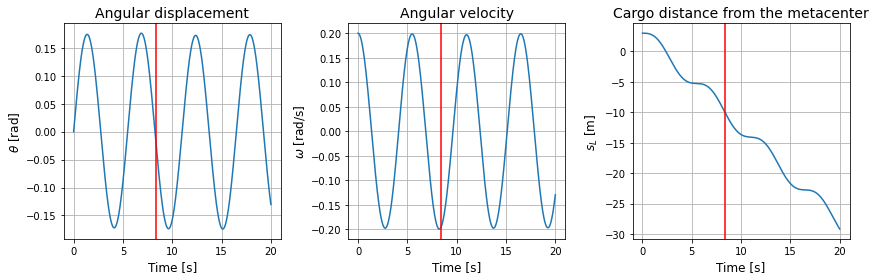

Mass ratio of ship: 0.08
The load falls off after: 11.983 seconds - given by red line in plot


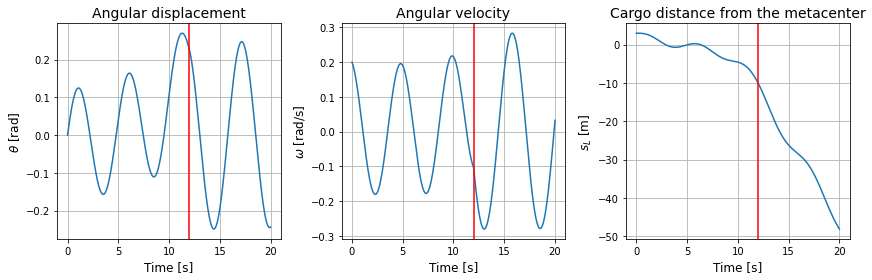

In [22]:
def RK4FallingCargo(derivative, b0, ta, tb, dt, *, retstep=False, **fkwargs):
    """Runs the Runge-Kutta of method the 4th order on the given input, with a check for capsizing, and for the cargo falling off

    - If the ship capsizes, the rest of the time-steps are filled with a capsized state
    - If the cargo falls off, its mass is set to 0 for the remainder of the simulation, thus removing its influence from the system

    Args:
        derivative (callable(float, np.ndarray, **kwargs)->np.ndarray): Derivative function, returns array of derivative of each element in the input array
        b0 (np.ndarray): initial state of the system
        ta (float): start time
        tb (float): end time
        dt (float): approximate size of the time step
        retstep (bool, optional): If True, return (t, w_array, box_fall, step), where step is the spacing between samples. Defaults to False.

    Returns:
        tuple[np.ndarray, np.ndarray, int]: array of times, the corresponding evaluated system states and the index the box falls off on (-1 if still on)
    """

    num_iter = int((tb-ta)/dt)
    t, dt = np.linspace(ta, tb, num_iter + 1, retstep=True)
    w_array = np.zeros((len(b0), num_iter + 1))
    w_array[:, 0] = b0

    beta, err = calculate_beta(fkwargs['cargo_mass'])
    fkwargs['beta'] = beta
    box_on = True
    box_off_index = -1
    for i in range(num_iter):
        wn = RK4Step(derivative, w_array[:, i], t[i], dt, **fkwargs)
        if box_on and abs(wn[6]) > SHIP_RADIUS:
            box_on = False
            box_off_index = i
            fkwargs['beta'] = BETA
            fkwargs['cargo_mass'] = 0
        if isCapsized(wn[0], wn[2]):
            w_array[0, i+1:] = np.sign(w_array[0, i])*np.pi*0.5
            break
        w_array[:, i+1] = wn

    # Returning results
    if retstep:
        return t, w_array, box_off_index, dt
    return t, w_array, box_off_index


def solveODEFallingCargo(cargo_mass):
    """Uses the RK4 method to simulate a system with cargo with given mass that can fall off

    Args:
        cargo_mass (float): Total mass of the cargo
    """
    ta, tb, dt = 0, 20, 0.001
    beta, err = calculate_beta(cargo_mass)
    y_M_0 = SHIP_RADIUS*np.cos(beta/2)
    y_C_0 = y_M_0 - DISTANCE_MC
    b0 = np.array([0, 0.2, y_C_0, 0,  0, 0, 3, 0])
    t, result, box_fall = RK4FallingCargo(derivative_cargo, b0, ta, tb, dt, cargo_mass=cargo_mass)

    theta = result[0]
    omega = result[1]
    s_L = result[6]

    if box_fall != -1:
        print(f'The load falls off after: {t[box_fall]} seconds - given by red line in plot')

    np.savez(f"FallingCargo_{cargo_mass:.1f}.npz", t=t, w=result)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    ax1.plot(t, theta)
    ax1.set_title("Angular displacement", fontsize=14)
    ax1.set_xlabel('Time [s]', fontsize=12)
    ax1.set_ylabel('$\\theta$ [rad]', fontsize=12)
    ax1.axvline(x=t[box_fall], color='r', label='cargo falls off')
    ax1.grid(True)

    ax2.plot(t, omega)
    ax2.set_title("Angular velocity", fontsize=14)
    ax2.set_xlabel('Time [s]', fontsize=12)
    ax2.set_ylabel('$\\omega$ [rad/s]', fontsize=12)
    ax2.axvline(x=t[box_fall], color='r', label='cargo falls off')
    ax2.grid(True)

    ax3.plot(t, s_L)
    ax3.set_title("Cargo distance from the metacenter", fontsize=14)
    ax3.set_xlabel('Time [s]', fontsize=12)
    ax3.set_ylabel('$s_L$ [m]', fontsize=12)
    ax3.axvline(x=t[box_fall], color='r', label='cargo falls off')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()


def testFallingCargo():
    """Tests the falling cargo method for different values of cargo mass
    """
    for mass_ratio in (0.001, 0.08):
        cargo_mass = mass_ratio * SHIP_MASS
        print(f'Mass ratio of ship: {mass_ratio}')
        solveODEFallingCargo(cargo_mass)


testFallingCargo()


With the additional weight from the cargo we see that the equillibrium distance from the water surface to the ship deck is decreased. This happens because the effective density of the ship increases, meaning that more bouyance force is needed to compensate for the increased gravitational force, thus causing the ship to sink further into the water. When the cargo falls of the ship, this effect becomes especially apparent, because the ship suddenly jumps up due to the decreased gravitational force, as can be seen from the sudden change in the angular displacement graph.

We see that when the mass is very small in relation to the ship's mass, in this example 0.1% of the ship's mass, the mass will have little effect on the dynamics of the system. This is especially clear since the theta before the cargo falls off, and after the box falls off, are almost identical. The movement of the cargo also becomes quite linear as a result of its small mass, as it only follows the harmonic oscillation of the ship.

If we look at heavier cargo, in this example 8% of the ship's mass, we see another trend. First, it affects the swinging motion of the ship considerably more. Heavier mass seems to reduce the amplitude the ship swings with, which intuitively makes sense, as heavier cargos push the ship down. The cargo, in turn, is also more affected by the ship, which is visible in the graph of $s_L$. Now the cargo does not follow a linear trend anymore, but it is flatter. This makes sense, since according to Newton's second law it is more difficult to move on a body of greater mass. This also contributes to a certain extent to the cargo falling off later.

## 2e)

In reality, ships have some form of barrier on the outer edges of the deck. We will implement this here, and it will then result in the cargo not falling off. The cargo will then crash into the edge, lose all its speed, and remain at the edge. We disregard forces that may act between the edge and the cargo.

Mass ratio of ship: 0.001


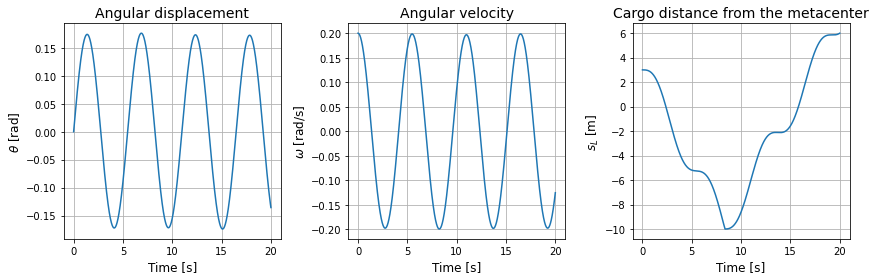

Mass ratio of ship: 0.08


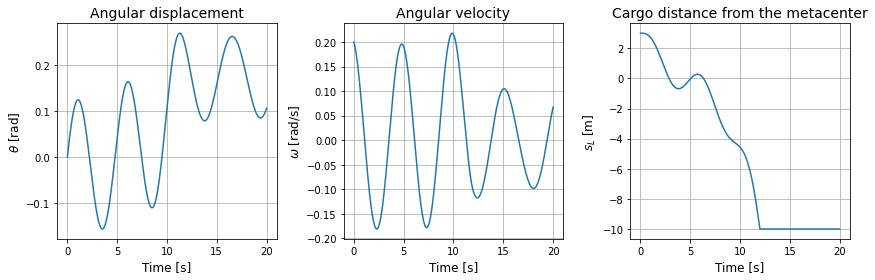

In [23]:
def RK4Railing(derivative, b0, ta, tb, dt, *, retstep=False, **fkwargs):
    """Runs the Runge-Kutta of method the 4th order on the given input, with a check for capsizing, and holds the cargo inside with railings

    - If the ship capsizes, the rest of the time-steps are filled with a capsized state
    - If the cargo should falls off, it is completely stopped by a "fence", disregarding the physicalities of that

    Args:
        derivative (callable(float, np.ndarray, **kwargs)->np.ndarray): Derivative function, returns array of derivative of each element in the input array
        b0 (np.ndarray): initial state of the system
        ta (float): start time
        tb (float): end time
        dt (float): approximate size of the time step
        retstep (bool, optional): If True, return (t, w_array, step), where step is the spacing between samples. Defaults to False.

    Returns:
        tuple[np.ndarray, np.ndarray]: array of times, and the corresponding evaluated system states
    """

    num_iter = int((tb-ta)/dt)
    t, dt = np.linspace(ta, tb, num_iter + 1, retstep=True)
    w_array = np.zeros((len(b0), num_iter + 1))
    w_array[:, 0] = b0
    beta, err = calculate_beta(fkwargs['cargo_mass'])
    fkwargs['beta'] = beta

    for i in range(num_iter):
        wn = RK4Step(derivative, w_array[:, i], t[i], dt, **fkwargs)
        if abs(wn[6]) > SHIP_RADIUS:
            wn[6] = SHIP_RADIUS*np.sign(wn[6])
            wn[7] = 0
        if isCapsized(wn[0], wn[2]):
            w_array[0, i+1:] = np.sign(w_array[0, i])*np.pi*0.5
            break
        w_array[:, i+1] = wn

    # Returning results
    if retstep:
        return t, w_array, dt
    return t, w_array


def solveODERailing(cargo_mass):
    """Uses the RK4 method to simulate a system with cargo with given mass which is held on the ship by railings

    Args:
        cargo_mass (float): Total mass of the cargo
    """
    ta, tb, dt = 0, 20, 0.001
    beta, err = calculate_beta(cargo_mass)
    y_M_0 = SHIP_RADIUS*np.cos(beta/2)
    y_C_0 = y_M_0 - DISTANCE_MC
    b0 = np.array([0, 0.2, y_C_0, 0,  0, 0, 3, 0])
    t, result = RK4Railing(derivative_cargo, b0, ta, tb, dt, cargo_mass=cargo_mass)

    theta = result[0]
    omega = result[1]
    s_L = result[6]

    np.savez(f"Railing_{cargo_mass:.1f}.npz", t=t, w=result)


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    ax1.plot(t, theta)
    ax1.set_title("Angular displacement", fontsize=14)
    ax1.set_xlabel('Time [s]', fontsize=12)
    ax1.set_ylabel('$\\theta$ [rad]', fontsize=12)
    ax1.grid(True)

    ax2.plot(t, omega)
    ax2.set_title("Angular velocity", fontsize=14)
    ax2.set_xlabel('Time [s]', fontsize=12)
    ax2.set_ylabel('$\\omega$ [rad/s]', fontsize=12)
    ax2.grid(True)

    ax3.plot(t, s_L)
    ax3.set_title("Cargo distance from the metacenter", fontsize=14)
    ax3.set_xlabel('Time [s]', fontsize=12)
    ax3.set_ylabel('$s_L$ [m]', fontsize=12)
    ax3.grid(True)

    plt.tight_layout()
    plt.show()


def testRailing():
    """Tests the method with railings for cargo for different values of cargo mass
    """
    for mass_ratio in (0.001, 0.08):
        cargo_mass = mass_ratio * SHIP_MASS
        print(f'Mass ratio of ship: {mass_ratio}')
        solveODERailing(cargo_mass)


testRailing()


We tested this result for two different masses placed three meters to the right of the metacenter, of very different magnitudes, and we observe two very different results that are worth discussing.

The first result, where the mass of the cargo is set equal to 0.1% of the ship's mass. It is expected that it will not have a major impact on the rotational dynamics of the ship. This is evident from the graph of the angular displacement. We also see that the cargo itself is thrown around the ship to a greater extent, for instance, it has lesser tendency to stick to one of the edges and remain there. We also notice that the ship affects the cargo far more than the cargo affects the ship.

For the second result, where the of the cargo equal to 8% of the ship's mass. We now see that the cargo has a significantly greater impact on the rotational dynamics of the ship. After about 10 seconds into the simulation, the cargo gets stuck to the railing and remains there for the rest of the simulation. The mass oscillates quite a bit before it gets stuck. It generely moves towards the left edge, with only minor deviations from a rectilinear path. This shows that the rotation of the ship only has a minor impact on the movement of the cargo. The cargo is stopped at the fence, in a non-physical way, by completely removing its velocity, and thus conserving neighter energy nor momentum. After the collision, the cargo remains in an unphysical state, where the interaction between the cargo and the fence is neglected, thus the cargo held is in place by a non-physical force. This causes the ship to remain oscillating with a lower amplitude and about a midpoint pointed towards the cargo. 

## 2f)

Water is in reality a viscous liquid, and thus there will be some form of friction between the ship's hull and the water, and we will now consider this force. The friction actually acts on every point of the hull that is in contact with the water, but we assume for the sake of simplicity that the net total frictional force only acts on the point D.

Another external force that we want to model is wind and waves. These are believed to be periodic forces, which act on the height of the water.

Both the friction force and the wave / wind force will result in a torque. Uses newton's second law of rotation to find an expression for the angular acceleration.

$$ \frac{d\omega}{dt} = \frac{\sum\tau}{I_C} = \frac{\tau_B + \tau_L + \tau_f + \tau_\omega}{I_C} = \frac{-F_B h \sin(\theta) - m_Lg\cos(\theta)s_L - f(y_C - R(\cos(\frac{\gamma}{2}) - 1)) + F_wy_C}{I_C} $$

The forces in the y-direction will remain unchanged, since the friction and wind / wave force are forces that only work in the x-direction.

$$ \frac{dv_y}{dt} = \frac{\sum F_y}{m} = \frac{A\sigma_0g - mg - m_Lg\cos^2(\theta) }{m} $$

The sum of the forces in the x-direction, on the other hand, has changed, with the addition of the wind / wave force and the friction force. Then the expression looks like this:

$$ \frac{dv_x}{dt} = \frac{\sum F_x}{m} = \frac{ m_Lg\cos(\theta)\sin(\theta) + F_0\cos(\omega_\omega t) - k_fR\gamma\omega}{m} = \frac{ m_Lg\sin(2\theta) }{2m} + \frac{F_0\cos(\omega_\omega t)}{m} - \frac{k_fR\gamma\omega}{m} $$

the load dynamics will remain unchanged, and thus:
$$ \frac{dv_L}{dt} = \frac{\sum F_{cargo}}{m} = -g\sin(\theta) $$

$$ \vec w = [\theta, \omega, y_c, v_{yc}, x_c, v_{xc}, s_L, v_L] $$
$$ \vec f = [\omega, \frac{d\omega}{dt} , v_{yc}, \frac{dv_{yc}}{dt}, v_{xc}, \frac{dv_{xc}}{dt}, \frac{ds_L}{dt}, \frac{dv_L}{dt}] $$



$\vec f =
\begin{pmatrix} 
      \omega \\ \\
      \frac{-F_B h \sin(\theta) - m_L g \cos{(\theta)} s_L - k_f R \gamma \omega (y_c + R(1 - \cos{\frac{\gamma}{2}})) + F_0 \cos{(\omega_{\omega} t)} y_c}{I_C} \\ \\
      y_c \\ \\
      \frac{F_B -g(m + m_L \cos^2{(\theta)})}{m} \\ \\
      v_{xc} \\ \\
      \frac{m_L g \sin{(\theta)} \cos{(\theta)}}{m}+ \frac{F_0 \cos{(\omega_{\omega} t)}}{m} - \frac{k_f R \gamma \omega}{m} \\ \\
      v_L \\ \\
      -g \sin {(\theta)}
   \end{pmatrix}
$



In [24]:
def derivative_wind_friction(t, w, **kwargs):
    """Calculates the derivative of w, considering: 
    
    - The buoyance force
    - The gravitational force
    - The dynamics of the cargo
    - Wind oscillations
    - Water friction

    Args:
        t (float): time
        w (np.ndarray): vector of form [theta, omega, y_C, v_yC, x_C, v_xC, s_L, v_L]
        kwargs ("dict"): must contain: 'cargo_mass', 'k_f', 'force_wind0', 'omega_omega'

    Returns:
        np.ndarray: derivative of form [d theta, d omega, d y_C, d v_yC, d x_C, d v_xC, d s_L, d v_L]
    """
    cargo_mass, k_f, force_wind0, omega_omega = itemgetter('cargo_mass', 'k_f', 'force_wind0', 'omega_omega')(kwargs)
    beta = kwargs.get('beta', BETA)

    y_M_0 = SHIP_RADIUS*np.cos(beta/2)
    y_C_0 = y_M_0 - DISTANCE_MC
    delta_Yc = w[2] - y_C_0
    gamma = 2*np.arccos(np.cos(beta*0.5) - (4/(3*np.pi)) * (1 - np.cos(w[0])) + delta_Yc/SHIP_RADIUS)
    area_water = 0.5*SHIP_RADIUS**2 * (gamma - np.sin(gamma))
    force_buoy = GRAV_ACC*WATER_DENSITY*area_water  # [N] buoyancy force
    force_grav = GRAV_ACC*SHIP_MASS
    force_cargo_normal = GRAV_ACC*cargo_mass*np.cos(w[0])

    force_wind = force_wind0*np.cos(omega_omega * t)
    force_friction = k_f * SHIP_RADIUS * gamma * w[1]

    return np.array([w[1],
                    (-force_buoy*DISTANCE_MC*np.sin(w[0]) - force_cargo_normal*w[6] + force_wind*w[2] - force_friction * (w[2] + SHIP_RADIUS*(1 - np.cos(gamma/2)))) / SHIP_INERTIA,
                    w[3],
                    (force_buoy - force_grav - force_cargo_normal*np.cos(w[0]))/SHIP_MASS,
                    w[5],
                    (force_cargo_normal*np.sin(w[0]) + force_wind - force_friction)/SHIP_MASS,
                    w[7],
                    -GRAV_ACC * np.sin(w[0])])


In [25]:
def solveODEFriction(*, cargo_mass=0, k_f=0, force_wind0, omega_omega):
    """Uses the RK4 method to simulate a system with cargo, water friction and wind force on a ship with railings

    Args:
        force_wind0 (float): Amplitude of the wind force
        omega_omega (float): Frequency of the wind
        cargo_mass (float, optional): Total mass of the cargo. Defaults to 0.
        k_f (float, optional): Friction coefficient. Defaults to 0.
    """
    ta, tb, dt = 0, 20, 0.005

    beta, err = calculate_beta(cargo_mass)
    y_M_0 = SHIP_RADIUS*np.cos(beta/2)
    y_C_0 = y_M_0 - DISTANCE_MC
    b0 = np.array([0, 0.2, y_C_0, 0, 0, 0, 3, 0])
    t, result = RK4Railing(derivative_wind_friction, b0, ta, tb, dt,
                                           cargo_mass=cargo_mass, k_f=k_f, force_wind0=force_wind0, omega_omega=omega_omega)
    np.savez(f"friction_{k_f:.1f}.npz", t=t, w=result)

    plt.figure(figsize=(5, 5))
    plt.plot(t, np.rad2deg(result[0]))
    plt.title(f"Angular displacement for k_f={k_f}", fontsize=18)
    plt.xlabel('Time [s]', fontsize=16)
    plt.ylabel('$\\theta$ [deg]', fontsize=16)
    plt.grid(True)
    plt.show()


We first only want to study how different coefficients of friction affect the dynamics of the ship. Then we assume that we are in calm waters, where we can set $F_0$ equal to zero. We also disregard cargo on the ship. 

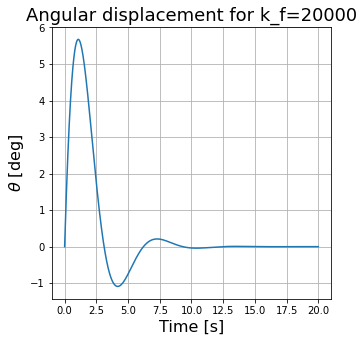

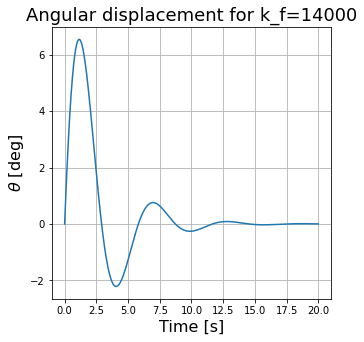

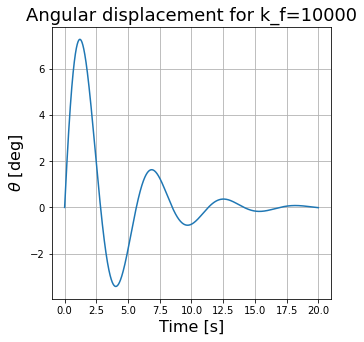

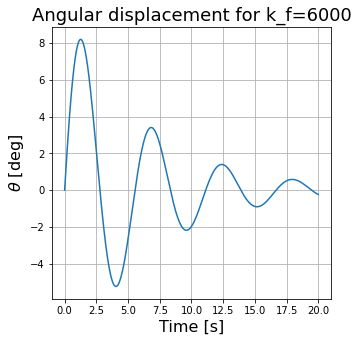

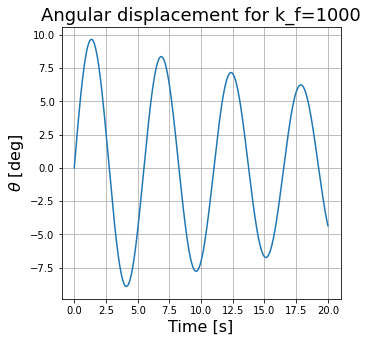

In [26]:
def testFriction():
    """Tests the method with different values of friction coefficients
    """
    for k_f in (20_000, 14_000, 10_000, 6_000, 1_000):
        solveODEFriction(cargo_mass=0, k_f=k_f, force_wind0=0, omega_omega=0)


testFriction()

The first thing that stands out is that the higher the coefficient of friction we choose, the more attenuated the oscillations. This is evident from the angular displacement graphs, which shows fewer oscilations at greater friction coefficients. This implies that the oscillations are dampened meaning that they eventually die out, which is to be expected when we introduce friction.

## 2g)

We will now turn our attention towards forced oscillations. Consider this force as a simplified model describing both how wind and waves affect the ship. We will not be considering cargo at this point in order to limit the noise in our findings. 

In [27]:
def solveODEWind(*, cargo_mass=0, k_f=0, force_wind0, omega_omega):
    """Uses the RK4 method to simulate a system with cargo, water friction and wind force on a ship with railings over longer time

    Args:
        force_wind0 (float): Amplitude of the wind force
        omega_omega (float): Frequency of the wind
        cargo_mass (float, optional): Total mass of the cargo. Defaults to 0.
        k_f (float, optional): Friction coefficient. Defaults to 0.
    """
    ta, tb, dt = 0, 240, 0.005

    beta, err = calculate_beta(cargo_mass)
    y_M_0 = SHIP_RADIUS*np.cos(beta/2)
    y_C_0 = y_M_0 - DISTANCE_MC
    b0 = np.array([0, np.deg2rad(2), y_C_0, 0, 0, 0, 3, 0])
    t, result = RK4Railing(derivative_wind_friction, b0, ta, tb, dt,
                                           cargo_mass=cargo_mass, k_f=k_f, force_wind0=force_wind0, omega_omega=omega_omega)
    np.savez(f"Wind.npz", t=t, w=result)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    ax1.set_title("Angular displacement", fontsize=14)
    ax1.set_xlabel('Time [s]', fontsize=12)
    ax1.set_ylabel('$\\theta$ [deg]', fontsize=12)
    ax1.plot(t, np.rad2deg(result[0]))
    ax1.grid(True)

    ax2.set_title("Longitudinal displacement of center of mass", fontsize=14)
    ax2.set_xlabel('Time [s]', fontsize=12)
    ax2.set_ylabel('$y_c$ [m]', fontsize=12)
    ax2.plot(t, result[2])
    ax2.grid(True)

    ax3.set_title("Latitudinal displacement of center of mass", fontsize=14)
    ax3.set_xlabel('Time [s]', fontsize=12)
    ax3.set_ylabel('$x_c$ [m]', fontsize=12)
    ax3.plot(t, result[4])
    ax3.grid(True)

    ax4.set_title("Cargo distance from the metacenter", fontsize=14)
    ax4.set_xlabel('Time [s]', fontsize=12)
    ax4.set_ylabel('$s_L$ [m]', fontsize=12)
    ax4.plot(t, result[6])
    ax4.grid(True)

    plt.tight_layout()
    plt.show()


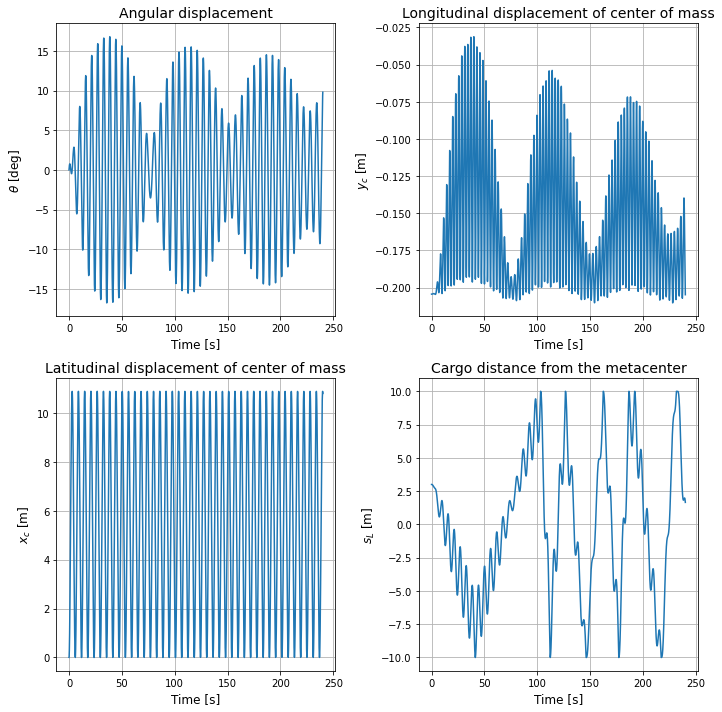

In [28]:
def testBeat():
    """Adds a harmonic wind force with frequency close to the resonance frequency of the boat, creating what can be seem as beats
    """
    # [N] amplitude to harmonic force due to wind / waves
    F_0 = 0.625*SHIP_MASS*GRAV_ACC
    # [rad/s] wind frequency
    omega_omega = 0.93*RESONANCE_FREQUENCY

    solveODEWind(cargo_mass=0, k_f=100,
                force_wind0=F_0, omega_omega=omega_omega)


testBeat()


From the graphs we observe that the introduction of forced oscillations causes the beat phenomenon to appear. This is a phenomenon that occurs when multiple oscillations with similar frequencies occur in tandem with one another, and it's a form of interference. So the fact that we observe this phenomenon here shouldn't be a surprise, as we have introduced a force with approximately the same frequency as ship. 

A noticeable result is that the beat amplitude and the width of each beat do not remain unchanged. It seems that the beat amplitude decreases over time, and that the width of the beats increases over time. In other words, the beat phenomenon becomes less well defined over time. This is a result of the frictional force acting between the ship and the water. As a result of friction, the natural frequency of the ship will decrease over time. The natural frequency of the wind / waves remains unchanged. Thus, the beat phenomenon will be less over time.

## 2h)

As an additional complication, we will now consider friction between the boat and the cargo. This will affect both the boat and the cargo by adding forces to the cargo and the boat, and a torque to the boat. This will add to the realism of the model, whilst adding an easily describable complication.
Note however that we are in effect choosing $\mu_s = 0$, we can justify this because the main consequence of $\mu_s > 0$ is that the cargo would get stuck to the railings, because they function by forcing $v_L = 0$, but this is undesirable because that particular effect is non physical. Thus such an effect would probably lead to a less realistic model.

The friction takes the following form (note that the friction is in the opposite direction of the movement of the cargo):

$$ f_{cargo} = -\mu N sgn(v_L) $$

Where normal force can be written as:

$$ N = m_Lg\cos(\theta) $$

Thus:

$$ f_{cargo} = -\mu m_Lg\cos(\theta) sgn(v_L) $$

And as a result of Newton's third law, we get:

$$ f_{ship} = \mu m_Lg\cos(\theta)sgn(v_L) $$

This frictional force will provide a torque about the ship's center of mass. It is easily seen that the load always has an arm of the constant length $h$, and we therefore get the surprisingly nice expression:

$$ \tau = \mu m_Lg\cos(\theta)h sgn(v_L)$$

From Newton's second law of rotation form, we thus get:

$$ \frac{d\omega}{dt} = \frac{\mu m_Lg\cos(\theta)h sgn(v_L)}{I_C} $$

The forces due to the friction in the y-direction and the x-direction are:

$$ f_{ship_y} =  -\mu m_Lg\cos(\theta) \sin(\theta) sgn(v_L)$$

$$ f_{ship_x} = \mu m_Lg\cos^2(\theta) sgn(v_L) $$

In [29]:
def derivativeCargoWind(t, w, **kwargs):
    """Calculates the derivative of w, considering: 
    
    - The buoyance force
    - The gravitational force
    - The dynamics of the cargo
    - Wind oscillations
    - Water friction
    - Kinetic friction for the cargo

    Args:
        t (float): time
        w (np.ndarray): vector of form [theta, omega, y_C, v_yC, x_C, v_xC, s_L, v_L]
        kwargs ("dict"): must contain: 'cargo_mass', 'k_f', 'force_wind0', 'omega_omega', 'mu'

    Returns:
        np.ndarray: derivative of form [d theta, d omega, d y_C, d v_yC, d x_C, d v_xC, d s_L, d v_L]
    """
    cargo_mass, k_f, force_wind0, omega_omega, mu = itemgetter('cargo_mass', 'k_f', 'force_wind0', 'omega_omega', 'mu')(kwargs)
    beta = kwargs.get('beta', BETA)

    y_M_0 = SHIP_RADIUS*np.cos(beta/2)
    y_C_0 = y_M_0 - DISTANCE_MC
    delta_Yc = w[2] - y_C_0
    gamma = 2*np.arccos(np.cos(beta*0.5) - (4/(3*np.pi)) * (1 - np.cos(w[0])) + delta_Yc/SHIP_RADIUS)
    area_water = 0.5*SHIP_RADIUS**2 * (gamma - np.sin(gamma))
    force_buoy = GRAV_ACC*WATER_DENSITY*area_water  # [N] buoyancy force
    force_grav = GRAV_ACC*SHIP_MASS
    force_cargo_normal = GRAV_ACC*cargo_mass*np.cos(w[0])
    force_cargo_friction = np.sign(w[7]) * mu*force_cargo_normal

    force_wind = force_wind0*np.cos(omega_omega * t)
    force_friction = k_f * SHIP_RADIUS * gamma * w[1]

    return np.array([w[1], 
                    (-force_buoy*DISTANCE_MC*np.sin(w[0]) - force_cargo_normal*w[6] + force_wind*w[2] - force_friction * (w[2] + SHIP_RADIUS*(1 - np.cos(gamma/2))) + force_cargo_friction*DISTANCE_MC)/SHIP_INERTIA, 
                    w[3], 
                    (force_buoy - force_grav - force_cargo_normal*np.cos(w[0]) - force_cargo_friction*np.sin(w[0]))/SHIP_MASS, 
                    w[5], 
                    (force_cargo_normal*np.sin(w[0]) + force_wind - force_friction + force_cargo_friction*np.cos(w[0]))/SHIP_MASS,
                    w[7], 
                    -GRAV_ACC * np.sin(w[0]) - force_cargo_friction/cargo_mass])


In [30]:
def solveODEMu(*, cargo_mass=0, k_f=0, force_wind0, omega_omega, mu):
    """Uses the RK4 method to simulate a system with cargo with kinetic friction, water friction, and wind force on a ship with railings

    Args:
        force_wind0 (float): Amplitude of the wind force
        omega_omega (float): Frequency of the wind
        mu (float): Friction coefficient
        cargo_mass (float, optional): Total mass of the cargo. Defaults to 0.
        k_f (float, optional): Friction coefficient. Defaults to 0.
    """
    ta, tb, dt = 0, 20, 0.005

    beta, err = calculate_beta(cargo_mass)
    y_M_0 = SHIP_RADIUS*np.cos(beta/2)
    y_C_0 = y_M_0 - DISTANCE_MC
    b0 = np.array([np.deg2rad(15), np.deg2rad(-1), y_C_0, 0,  0, 0, 3, 0])
    t, result = RK4Railing(derivativeCargoWind, b0, ta, tb, dt,
                                           cargo_mass=cargo_mass, k_f=k_f, force_wind0=force_wind0, omega_omega=omega_omega, mu=mu)
    np.savez(f"RK4Mu_{mu}.npz", t=t, w=result)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    ax1.set_title("Angular displacement\n", fontsize=14)
    ax1.set_xlabel('Time [s]', fontsize=12)
    ax1.set_ylabel('$\\theta$ [deg]', fontsize=12)
    ax1.plot(t, np.rad2deg(result[0]))
    ax1.grid(True)

    ax2.set_title("Longitudinal displacement of center of mass\n", fontsize=14)
    ax2.set_xlabel('Time [s]', fontsize=12)
    ax2.set_ylabel('$y_c$ [m]', fontsize=12)
    ax2.plot(t, result[2])
    ax2.grid(True)

    ax3.set_title("Latitudinal displacement of center of mass\n", fontsize=14)
    ax3.set_xlabel('Time [s]', fontsize=12)
    ax3.set_ylabel('$x_c$ [m]', fontsize=12)
    ax3.plot(t, result[4])
    ax3.grid(True)

    ax4.set_title("Cargo distance from the metacenter\n", fontsize=14)
    ax4.set_xlabel('Time [s]', fontsize=12)
    ax4.set_ylabel('$s_L$ [m]', fontsize=12)
    ax4.plot(t, result[6])
    ax4.grid(True)

    plt.tight_layout()
    plt.show()


There are several numerical methods for solving ordinary differential equations. Though the RK4 is widely used, there is value in other methods as well. We have chosen to consider the Bogacki-Shampine method. This method is an order 3/2 Runge-Kutta method, meaning that is composed of two Runge Kutta methods, one of order 3 and one of order 2, which allows us to determine an approximation for the global error with this method. We will use this error approximation to vary the stepsize throughout the process of solving an ODE, making it very efficient, since it doesn't waste resources on lighter parts of the ODE, whilst it uses a sufficient amount of resources on heavier parts of the ODE. This has a shortcomming, which will readily be apparent, which is that it may get stuck on solving an exceptionaly heavy part of an ODE, meaning that we will have no way of getting any information about what happens after this part. 

In [31]:
# Bogacki-Shampine-pair

def method1(w, h, k1, k2, k3):
    return w + h*(2/9*k1 + 1/3*k2 + 4/9*k3)

def method2(w, h, k1, k2, k3, k4):
    return w + h*(7/24*k1 + 1/4*k2 + 1/3*k3 + 1/8*k4)

def adaptiveODESolver(derivative, b0, ta, tb, h0, tol, P = 0.8, **fkwargs):
    # Declaring arrays
    t = np.array([ta])
    w = b0
    
    # Declaring variables
    p = 2
    hn = h0
    tn = ta
    wn = b0
    iterations = 0
    
    # Declaring the initial Runge-Kutta constants 
    k1 = derivative(tn, wn, **fkwargs)
    k2 = derivative(tn + 1/2*hn, wn + 1/2*hn*k1, **fkwargs)
    k3 = derivative(tn + 3/4*hn, wn + 3/4*hn*k2, **fkwargs)
    k4 = derivative(tn + hn, wn + hn*(2/9*k1 + 1/3*k2 + 4/9*k3), **fkwargs)
    
    while (tn < tb - 1.0e-10):
        if iterations >= 50_000:
            print("Too much work")
            break
        iterations += 1
        old_wn = wn
        
        # Changes h if it is too big
        if tn + hn > tb:
            hn = tb - tn

        m1 = method1(wn, hn, k1, k2, k3)
        m2 = method2(wn, hn, k1, k2, k3, k4)

        #Note that we are using the euclidean norm
        errorEstimate = np.linalg.norm(m2 - m1, 2) 
        if (errorEstimate <= tol): 
        #Accept changes
            tn += hn
            wn = m1
            w = np.c_[w, wn]
            t = np.append(t, tn)
            
        # Change based on conditions:
        if abs(wn[6]) > SHIP_RADIUS:
            wn[6] = old_wn[6]
            wn[7] = 0
        if isCapsized(wn[0], wn[2]):
            t = np.append(t, tn+hn)
            t = np.append(t, tb)
            bEnd = np.zeros(len(w))
            bEnd[0] = np.sign(wn[0])*np.pi*0.5
            w = np.c_[w, bEnd]
            w = np.c_[w, bEnd]
            break 
            
            
        # Adjusts stepsize   
        if errorEstimate != 0:
            hn = P * (tol/errorEstimate)**(1/(p+1)) * hn
        else:
            hn = h0
        
        # Adjusts Runge-Kutta constants 
        # k1_n+1 = k4_n, because method 1 agrees with k4 in terms of the koefficients of the k constants, and k4 is taken at the same  t-value as k1_n+1
        if (errorEstimate <= tol): 
            k1 = k4
        k2 = derivative(tn + 1/2*hn, wn + 1/2*hn*k1, **fkwargs)
        k3 = derivative(tn + 3/4*hn, wn + 3/4*hn*k2, **fkwargs)
        k4 = derivative(tn + hn, wn + hn*(2/9*k1 + 1/3*k2 + 4/9*k3), **fkwargs)
        
    
    # Returning results
    return t, w

In [32]:
def solveODEBogShamp(*, cargo_mass=0, k_f=0, force_wind0, omega_omega, mu):
    ta, tb, h0 = 0, 20, 0.01

    beta, err = calculate_beta(cargo_mass)
    y_M_0 = SHIP_RADIUS*np.cos(beta/2)
    y_C_0 = y_M_0 - DISTANCE_MC
    b0 = np.array([np.deg2rad(15), np.deg2rad(-1), y_C_0, 0,  0, 0, 3, 0])
    t, result = adaptiveODESolver(derivativeCargoWind, b0, ta, tb, h0, tol=1e-6,
                                  cargo_mass=cargo_mass, k_f=k_f, force_wind0=force_wind0, omega_omega=omega_omega, mu=mu)
    np.savez(f"BogShampMu_{mu}.npz", t=t, w=result)


    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    ax1.set_title("Angular displacement\n", fontsize=14)
    ax1.set_xlabel('Time [s]', fontsize=12)
    ax1.set_ylabel('$\\theta$ [deg]', fontsize=12)
    ax1.plot(t, np.rad2deg(result[0]))
    ax1.grid(True)

    ax2.set_title("Longitudinal displacement of center of mass\n", fontsize=14)
    ax2.set_xlabel('Time [s]', fontsize=12)
    ax2.set_ylabel('$y_c$ [m]', fontsize=12)
    ax2.plot(t, result[2])
    ax2.grid(True)

    ax3.set_title("Latitudinal displacement of center of mass\n", fontsize=14)
    ax3.set_xlabel('Time [s]', fontsize=12)
    ax3.set_ylabel('$x_c$ [m]', fontsize=12)
    ax3.plot(t, result[4])
    ax3.grid(True)

    ax4.set_title("Cargo distance from the metacenter\n", fontsize=14)
    ax4.set_xlabel('Time [s]', fontsize=12)
    ax4.set_ylabel('$s_L$ [m]', fontsize=12)
    ax4.plot(t, result[6])
    ax4.grid(True)

    plt.tight_layout()
    plt.show()


mu = 0.5
Bogacki-Shampine
Too much work


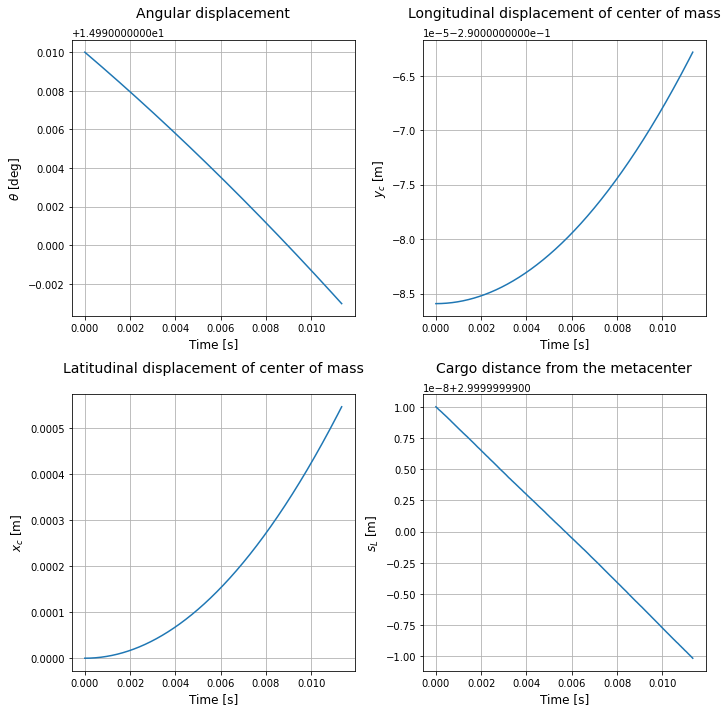

RK4


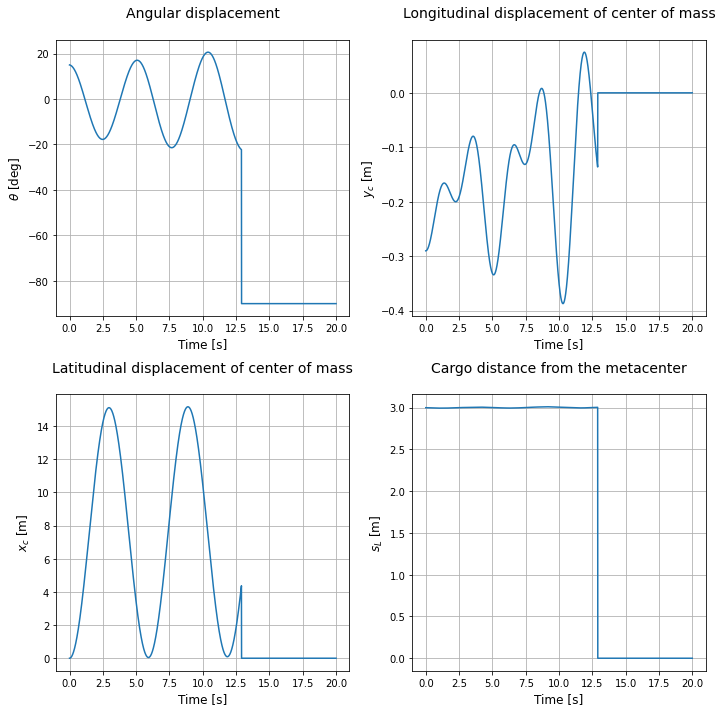

mu = 0.05
Bogacki-Shampine


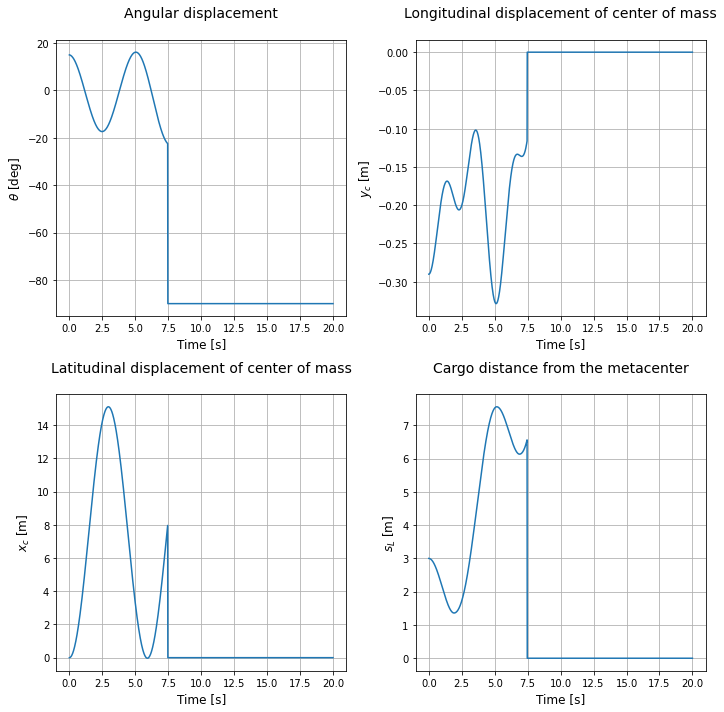

RK4


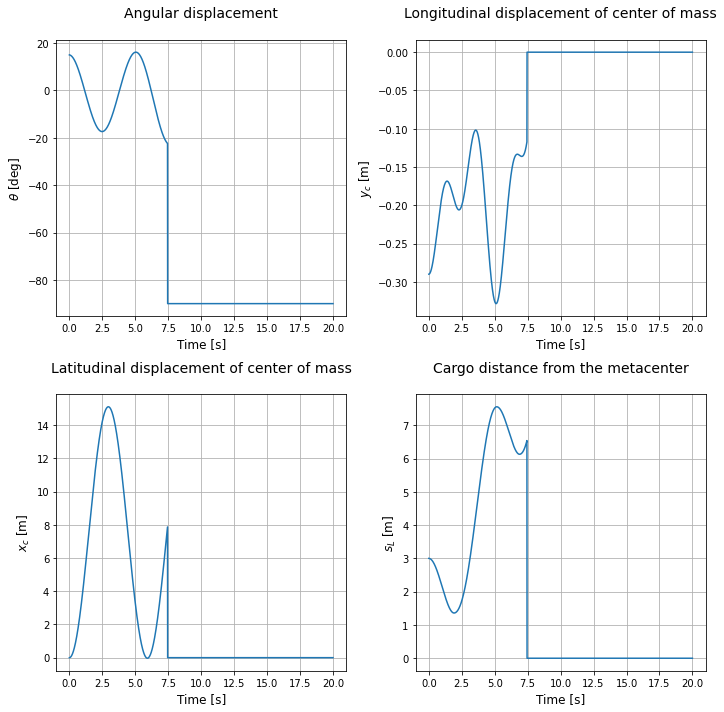

mu = 0.005
Bogacki-Shampine


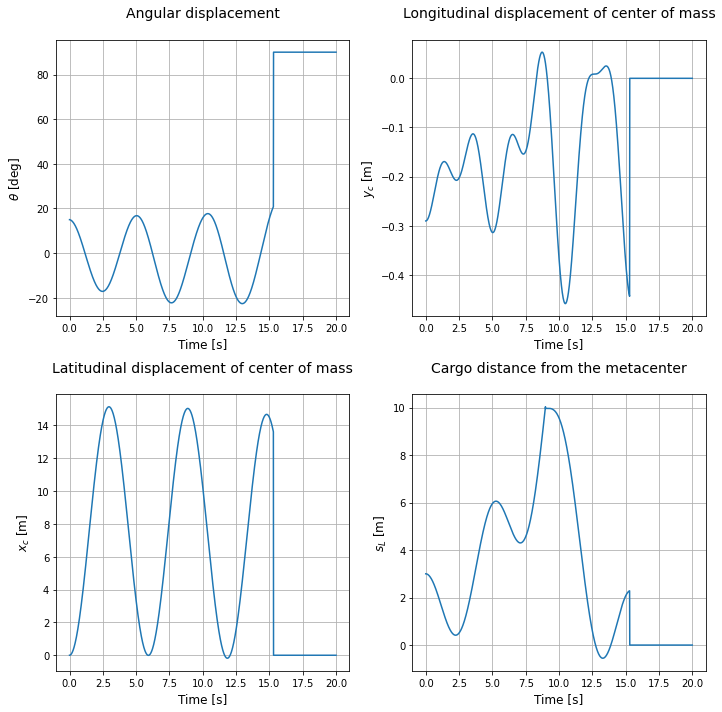

RK4


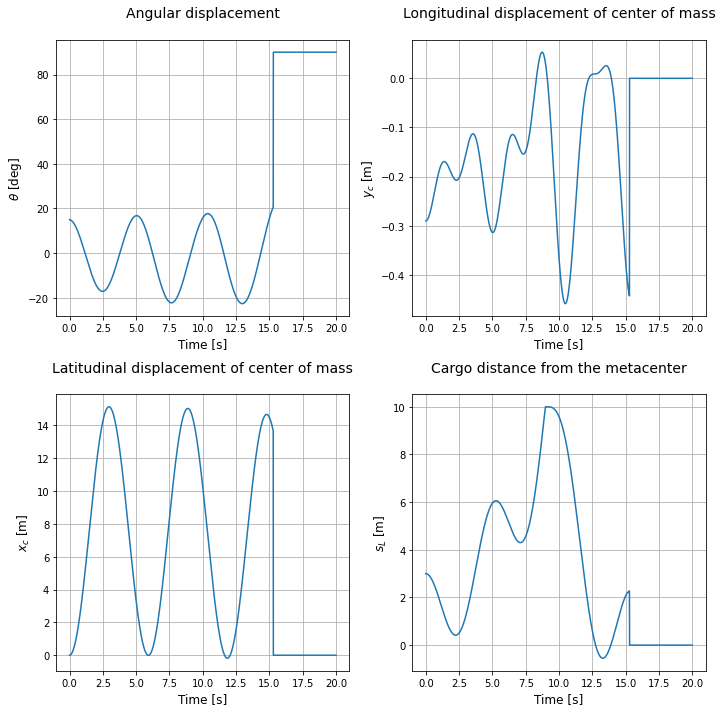

In [33]:
def testRK4andBogShamp():
    cargo_mass = 0.02*SHIP_MASS
    k_f = 100
    F_0 = 0.865*SHIP_MASS*GRAV_ACC
    omega_omega = 0.93*RESONANCE_FREQUENCY
    for mu in (0.5, 0.05, 0.005):
        print(f"mu = {mu}")
        print("Bogacki-Shampine")
        solveODEBogShamp(cargo_mass=cargo_mass, k_f=k_f,
                             force_wind0=F_0, omega_omega=omega_omega, mu=mu)
        print("RK4")
        solveODEMu(cargo_mass=cargo_mass, k_f=k_f,
                                force_wind0=F_0, omega_omega=omega_omega, mu=mu)


testRK4andBogShamp()

We notice that some of the $\mu$ - values are too much work for the Bogacki-Shampine method to handle. Though we aren't certain about the exact reasoning, we suspect that the increased value for $\mu$ causes big spikes in the differential equation, which causes the error estimation to become big, causing the step size to shrink to such an extent that it effectivly halts. This highlights a problem with the Bogacki-Shampine method, as RK4 had little problem solving the same equations that the Bogacki-Shampine method halted at.

We wish to compare the Bogacki-Shampine method and RK4, so we are forced to use a non adaptive version of the Bogacki-Shampine method, to gaurantee the time intervals. This influences the results marginaly, as the actual use of the Bogacki-Shampine method is not realized. 

In [34]:
def nonAdaptiveBogShamp(derivative, b0, ta, tb, h0, **fkwargs):
    # Declaring arrays
    t = np.array([ta])
    w = b0
    
    # Declaring variables
    p = 2
    hn = h0
    tn = ta
    wn = b0
    
    # Declaring the initial Runge-Kutta constants 
    k1 = derivative(tn, wn, **fkwargs)
    k2 = derivative(tn + 1/2*hn, wn + 1/2*hn*k1, **fkwargs)
    k3 = derivative(tn + 3/4*hn, wn + 3/4*hn*k2, **fkwargs)
    k4 = derivative(tn + hn, wn + hn*(2/9*k1 + 1/3*k2 + 4/9*k3), **fkwargs)
    
    while (tn < tb - 1.0e-10):
        old_wn = wn
        
        # Changes h if it is too big
        if tn + hn > tb:
            hn = tb - tn

        m1 = method1(wn, hn, k1, k2, k3)
        m2 = method2(wn, hn, k1, k2, k3, k4)

        tn += hn
        wn = m1
        w = np.c_[w, wn]
        t = np.append(t, tn)
            
        # Change based on conditions:
        if abs(wn[6]) > SHIP_RADIUS:
            wn[6] = old_wn[6]
            wn[7] = 0
        if isCapsized(wn[0], wn[2]):
            t = np.append(t, tn+hn)
            t = np.append(t, tb)
            bEnd = np.zeros(len(w))
            bEnd[0] = np.sign(wn[0])*np.pi*0.5
            w = np.c_[w, bEnd]
            w = np.c_[w, bEnd]
            break 
            
        k1 = k4
        k2 = derivative(tn + 1/2*hn, wn + 1/2*hn*k1, **fkwargs)
        k3 = derivative(tn + 3/4*hn, wn + 3/4*hn*k2, **fkwargs)
        k4 = derivative(tn + hn, wn + hn*(2/9*k1 + 1/3*k2 + 4/9*k3), **fkwargs)
        
    
    # Returning results
    return t, w

In [35]:
def diffRK4Bogshamp(*, cargo_mass=0, k_f=0, force_wind0, omega_omega, mu):
    ta, tb, dt = 0, 20, 0.01

    beta, err = calculate_beta(cargo_mass)
    y_M_0 = SHIP_RADIUS*np.cos(beta/2)
    y_C_0 = y_M_0 - DISTANCE_MC
    b0 = np.array([np.deg2rad(10), np.deg2rad(1), y_C_0, 0,  0, 0, 3, 0])
    t, RK4 = RK4Railing(derivativeCargoWind, b0, ta, tb, dt,
                                        cargo_mass=cargo_mass, k_f=k_f, force_wind0=force_wind0, omega_omega=omega_omega, mu=mu)
    t, Bog = nonAdaptiveBogShamp(derivativeCargoWind, b0, ta, tb, dt,
                                 cargo_mass=cargo_mass, k_f=k_f, force_wind0=force_wind0, omega_omega=omega_omega, mu=mu)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    ax1.set_title("Difference in angular displacement between\nBogacki-Shampine and RK4\n", fontsize=14)
    ax1.set_xlabel('Time [s]', fontsize=12)
    ax1.set_ylabel('$\\theta$ [deg]', fontsize=12)
    ax1.plot(t, np.rad2deg(RK4[0] - Bog[0]))
    ax1.grid(True)

    ax2.set_title("Difference in longitudinal displacement of center\nof mass between Bogacki-Shampine and RK4\n", fontsize=14)
    ax2.set_xlabel('Time [s]', fontsize=12)
    ax2.set_ylabel('$y_c$ [m]', fontsize=12)
    ax2.plot(t, RK4[2] - Bog[2])
    ax2.grid(True)

    ax3.set_title("Difference in latitudinal displacement of center\nof mass between Bogacki-Shampine and RK4\n", fontsize=14)
    ax3.set_xlabel('Time [s]', fontsize=12)
    ax3.set_ylabel('$x_c$ [m]', fontsize=12)
    ax3.plot(t, RK4[4] - Bog[4])
    ax3.grid(True)

    ax4.set_title("Difference in distance from\nthe metacenter between POG and RK4\n", fontsize=14)
    ax4.set_xlabel('Time [s]', fontsize=12)
    ax4.set_ylabel('$s_L$ [m]', fontsize=12)
    ax4.plot(t, RK4[6] - Bog[6])
    ax4.grid(True)

    plt.tight_layout()
    plt.show()


mass ratio of ship: 0.05
coefficient of friction: 0.5


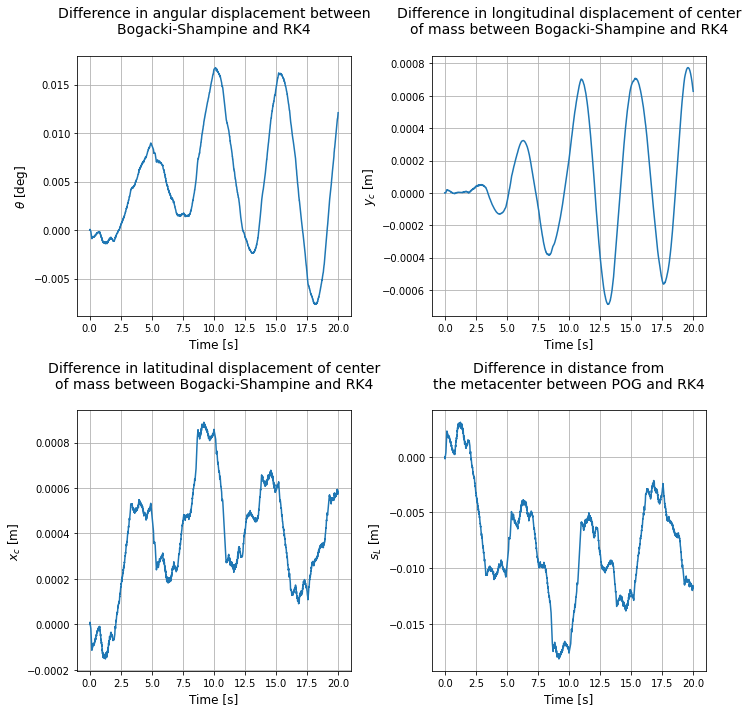

mass ratio of ship: 0.05
coefficient of friction: 0.005


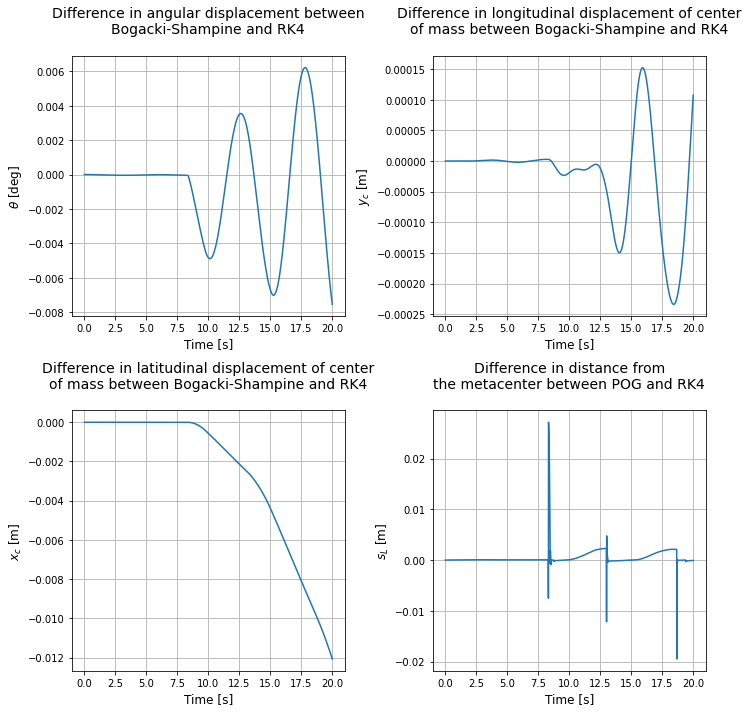

mass ratio of ship: 0.0005
coefficient of friction: 0.5


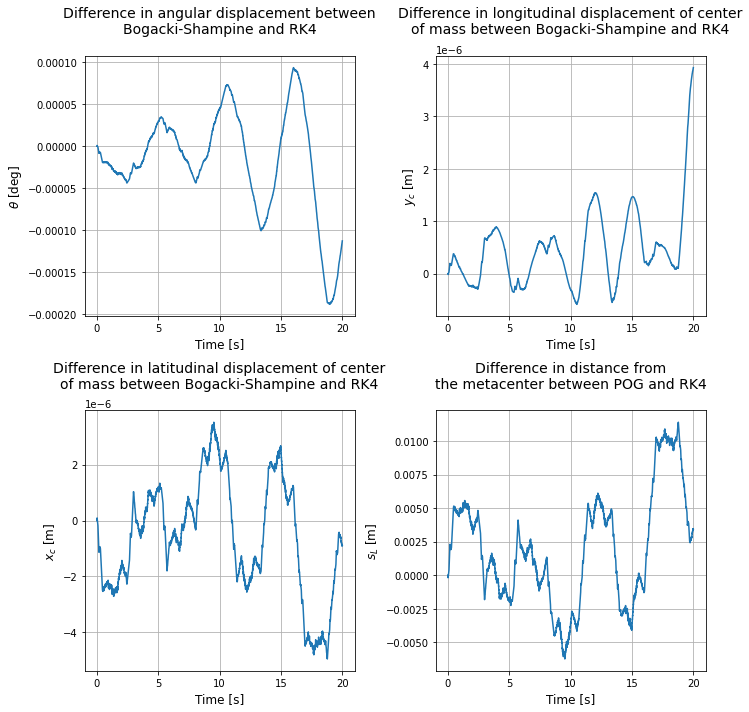

mass ratio of ship: 0.0005
coefficient of friction: 0.005


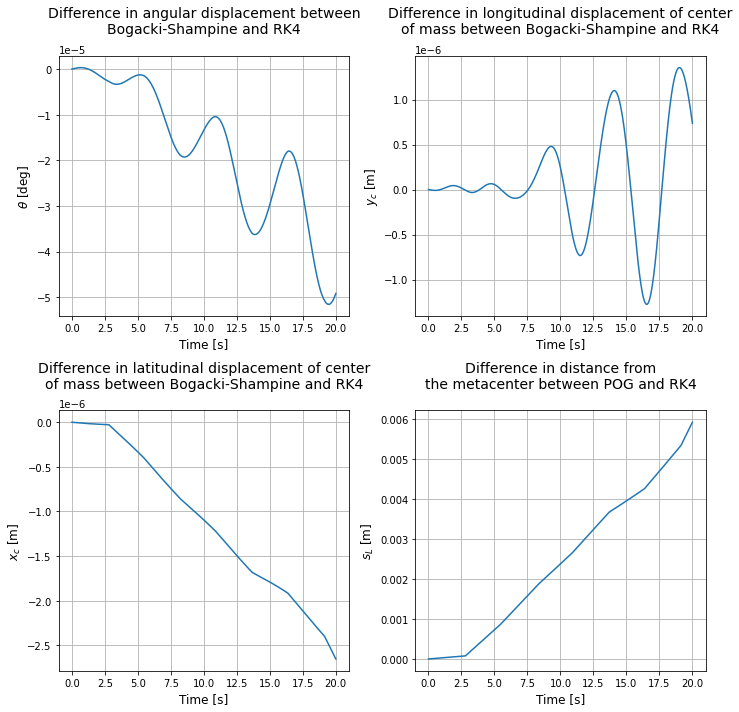

In [36]:
def testDifferenceRK4Bogshamp():

    mass_ratios = (0.05, 0.0005)
    k_f = 100
    F_0 = 0.100*SHIP_MASS*GRAV_ACC
    omega_omega = 0.93*RESONANCE_FREQUENCY
    mus = (0.5, 0.005)

    for mass_ratio in mass_ratios:
        for mu in mus:
            cargo_mass = mass_ratio*SHIP_MASS
            print(f'mass ratio of ship: {mass_ratio}')
            print(f'coefficient of friction: {mu}')
            diffRK4Bogshamp(cargo_mass=cargo_mass, k_f=k_f,
                            force_wind0=F_0, omega_omega=omega_omega, mu=mu)


testDifferenceRK4Bogshamp()

As can readily be seen from the graphs, decreasing the mass of the cargo, or decreasing the friction between the ship and the cargo, causes the differences between the two methods to decrease rapidly. This implies that the faults in the ODE solvers primarily come from properly dealing with the movement of the cargo, because lowering these two variables decrease the impact that the cargo has on the dynamics of the ship. 

This further shows one benefit of using different ODE solvers on the same problem, namely it gives a method for finding weaknessess in one or both of the methods. Though it is worth noting that we have no way to discerning which method is better with these results, so we have to assume that both methods function equally poorly at deal with the problem of tracking the cargo.

## Conclusion

We have in this notebook described the dynamics concerning a boat out on the open seas. To do this we were forced to make some assumptions in order to get a proper first grasp at a possible solution. For instance, we assumed that a two dimensional system captured the essence of the problem to such an extent that we could forgo concerning ourselves with the added complexity, which a third dimension would add. Certain assumptions we initially made were eventually remedied in order to get a more realistic model, though the assumptions aided in giving us a better understanding of the problem by simplifing it such that we could focus on one aspect at a time. 

Throughout the notebook we have used a variety of ODE solvers, namely: Euler's method, Runge-Kutta of order 4 and the Bogacki-Shampine method. We looked at Euler's method and small angle apporximations, and we found that the small angle approximation is valid for sufficently small angles, even when used for approximating differential equations.
We analyzed the difference in accuracy between Euler's method and RK4, we discovered that RK4 is significantly more accurate than Euler's method due it's order being 3 orders greater than that of Euler's method, we therefore chose to soley use RK4 for the remainder of the notebook, expect for at the end, where we also used the Bogacki-Shampine method.

When we eventually added a moving part to our boat model, we found that the boat had a tendency to move more chaoticly. This is because the movement of the cargo, and the rotation of the ship, given random initial values, don't correlate to a great effect. We noticed that light cargos resulted in only minor effects to the ship, given that the friction between the ship and the cargo was sufficiently low. 

We also considered exterior forces like friction and wind. The friction caused the ships movement to dampen over time, as is intuitivley what we would expect friction to cause. The wind caused the ship to move violently from side to side, and when the wind frequency was approximately equal to the ships resonant frequenct we found the beat phenomenon to appear, which we deemed to be because this was a system consisting of two similar frequencies. 

We found that the added friction between the ship and the cargo, caused the cargo to tend more to the railings of the ship for bigger friction coefficients, this was because the friction made it difficult for the cargo to move away from the railing once it had lost its speed.

When we compared RK4 to the Bogacki-Shampine method we found that the moving cargo caused big discrepancies, which implies that the ODE solvers have problems dealing with moving cargo accuratley, especially for heavier cargo when there is more friction.